In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class BernoulliBanditEnv(object): 
    # Clase que define el environment donde el reward es 0 o 1 dependiendo de una probabilidad p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # La mejor accion dado el enviroenmentenenas

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [97]:
class Agent(object):
    # Clase que define al agente. Cada agente cuenta con una regla de decisión y una regla de aprendizaje.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
        
        if decision_rule == "gradient":
            self.lr = param["lr"]
    
    def environment(self, env, init_q):
        # inicializa el environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta  = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # Guardo last_reward para el gradient bandits
        if self.decision_rule == "gradient":
            self.last_action = a
            self.last_reward = r
        
        # dada una acción y una recompenza, actualiza la value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a]  += 1 - r 
            
    def act(self):
        # realiza una acción.
        self.iteration += 1 
        
        if self.decision_rule == "greedy":
            selected_action = greedyAction(self.q_estimate)
            pass
        if self.decision_rule == "epsilon-greedy":
            selected_action = epsilonGreedyAction(self.q_estimate, self.epsilon)
            pass
        if self.decision_rule == "UCB":
            selected_action = upperConfidenceBoundAction(self.q_estimate, self.UCB_param, self.iteration, self.act_count)
            pass
        if self.decision_rule == "gradient":
            # Tomar H (self.pref) como mi funcion de preferencia que actualiza cuando compara
            # el reward R que obtuve con mi reward promedio estimado R^
            # Debo actualizar dos cosas:
            #    la preferencia de la accion que tome (aumenta o disminuye)
            #    la preferencia de las otras acciones (disminuyen o aumentan)
            if self.iteration == 1:
                # First action decision, without having rewards, so
                # equal preferences for each action
                self.pref = np.empty(self.k)
                self.pref.fill(0)#1.0/self.k)
            else:
                pi = softmax_vect(self.pref)
                # Obs: uso q_estimate como promedio de rewards, ya que acumula llevando la cuenta
                r_diff = self.last_reward - self.q_estimate[self.last_action]
                # one-hot vector with chosen last action
                indicactor = np.where(self.actions==self.last_action, np.ones(self.k), 0.0)
                self.pref += self.lr * r_diff * (indicactor-pi)
            pi = softmax_vect(self.pref)
            selected_action = np.random.choice(self.actions, p=pi)
            if np.any(np.mod(5*[self.iteration], 5*[100]) == np.arange(2,2+5)):
                print(self.iteration, self.pref,pi, selected_action, self.last_action, self.last_reward, r_diff )
            pass
        if self.decision_rule == "Thompson":
            # COMPLETAR
            pass
        self.act_count[selected_action] += 1
        return selected_action

In [98]:
5*[6]

[6, 6, 6, 6, 6]

2 [0. 0.] [0.5 0.5] 0 0 1 0.0
3 [-0.00075  0.00075] [0.499625 0.500375] 1 0 0 -0.5
4 [-0.00075  0.00075] [0.499625 0.500375] 0 1 1 0.0
5 [-0.00125037  0.00125037] [0.49937481 0.50062519] 0 0 0 -0.33333333333333337
6 [-0.00162584  0.00162584] [0.49918708 0.50081292] 1 0 0 -0.25
102 [ 0.00808702 -0.00808702] [0.50404342 0.49595658] 1 1 1 0.20833333333333326
103 [ 0.00925969 -0.00925969] [0.50462971 0.49537029] 1 1 0 -0.7755102040816327
104 [ 0.00892664 -0.00892664] [0.5044632 0.4955368] 1 1 1 0.21999999999999997
105 [ 0.00860022 -0.00860022] [0.5043 0.4957] 0 1 1 0.21568627450980393
106 [ 0.00793929 -0.00793929] [0.50396956 0.49603044] 1 0 0 -0.4444444444444446
202 [-0.00020683  0.00020683] [0.49989659 0.50010341] 1 1 1 0.1847826086956521
203 [-0.00048097  0.00048097] [0.49975952 0.50024048] 0 1 1 0.18279569892473113
204 [ 0.00039218 -0.00039218] [0.50019609 0.49980391] 0 0 1 0.5818181818181817
205 [ 0.00125671 -0.00125671] [0.50062835 0.49937165] 0 0 1 0.5765765765765765
206 [ 0.0021127

202 [ 0.01091668 -0.01091668] [0.50545812 0.49454188] 0 0 1 0.6391752577319587
203 [ 0.0118553 -0.0118553] [0.50592737 0.49407263] 0 0 1 0.6326530612244897
204 [ 0.01278356 -0.01278356] [0.50639143 0.49360857] 0 0 1 0.6262626262626262
205 [ 0.01223565 -0.01223565] [0.50611752 0.49388248] 0 0 0 -0.37000000000000005
206 [ 0.01315985 -0.01315985] [0.50657954 0.49342046] 1 0 1 0.6237623762376237
302 [ 0.01707573 -0.01707573] [0.50853704 0.49146296] 0 0 1 0.5949367088607596
303 [ 0.01794739 -0.01794739] [0.50897273 0.49102727] 1 0 1 0.5911949685534592
304 [ 0.01763988 -0.01763988] [0.50881903 0.49118097] 0 1 1 0.20138888888888873
305 [ 0.01704125 -0.01704125] [0.5085198 0.4914802] 1 0 0 -0.40624999999999994
306 [ 0.01673614 -0.01673614] [0.50836729 0.49163271] 1 1 1 0.19999999999999984
402 [ 0.02235731 -0.02235731] [0.51117679 0.48882321] 1 0 0 -0.41395348837209284
403 [ 0.02355461 -0.02355461] [0.51177513 0.48822487] 0 1 0 -0.7807486631016044
404 [ 0.024409 -0.024409] [0.51220208 0.4877979

102 [ 0.00407027 -0.00407027] [0.50203512 0.49796488] 1 1 1 0.13043478260869557
103 [ 0.003878 -0.003878] [0.50193899 0.49806101] 1 1 1 0.12765957446808507
104 [ 0.00368977 -0.00368977] [0.50184488 0.49815512] 1 1 1 0.125
105 [ 0.00350542 -0.00350542] [0.5017527 0.4982473] 1 1 1 0.12244897959183676
106 [ 0.00479994 -0.00479994] [0.50239995 0.49760005] 1 1 0 -0.86
202 [ 0.00722568 -0.00722568] [0.50361278 0.49638722] 1 0 1 0.7047619047619048
203 [ 0.00692975 -0.00692975] [0.50346482 0.49653518] 1 1 1 0.19587628865979367
204 [ 0.00663692 -0.00663692] [0.50331841 0.49668159] 0 1 1 0.19387755102040805
205 [ 0.00767714 -0.00767714] [0.50383849 0.49616151] 0 0 1 0.6981132075471699
206 [ 0.00870655 -0.00870655] [0.50435317 0.49564683] 0 0 1 0.691588785046729
302 [ 0.0097783 -0.0097783] [0.504889 0.495111] 1 0 0 -0.3051948051948052
303 [ 0.00947128 -0.00947128] [0.5047355 0.4952645] 0 1 1 0.20270270270270285
304 [ 0.00902074 -0.00902074] [0.50451025 0.49548975] 0 0 0 -0.3032258064516129
305 [ 

202 [ 0.00481145 -0.00481145] [0.50240571 0.49759429] 1 1 1 0.17525773195876293
203 [ 0.00604183 -0.00604183] [0.50302088 0.49697912] 0 1 0 -0.8163265306122448
204 [ 0.00553065 -0.00553065] [0.5027653 0.4972347] 1 0 0 -0.34285714285714297
205 [ 0.00525642 -0.00525642] [0.50262818 0.49737182] 1 1 1 0.18181818181818188
206 [ 0.004985 -0.004985] [0.50249248 0.49750752] 0 1 1 0.18000000000000005
302 [ 0.01037694 -0.01037694] [0.50518828 0.49481172] 0 0 0 -0.3749999999999999
303 [ 0.00982373 -0.00982373] [0.50491171 0.49508829] 1 0 0 -0.372670807453416
304 [ 0.00956772 -0.00956772] [0.50478371 0.49521629] 1 1 1 0.16901408450704214
305 [ 0.01081733 -0.01081733] [0.50540845 0.49459155] 0 1 0 -0.8251748251748253
306 [ 0.0117424 -0.0117424] [0.50587093 0.49412907] 0 0 1 0.6234567901234569
402 [ 0.00685056 -0.00685056] [0.50342523 0.49657477] 0 1 1 0.16753926701570665
403 [ 0.00778958 -0.00778958] [0.50389471 0.49610529] 0 0 1 0.6303317535545024
404 [ 0.00724199 -0.00724199] [0.50362093 0.496379

302 [ 0.0068563 -0.0068563] [0.5034281 0.4965719] 0 1 0 -0.7756410256410252
303 [ 0.00775421 -0.00775421] [0.50387703 0.49612297] 0 0 1 0.6027397260273971
304 [ 0.0086452 -0.0086452] [0.50432249 0.49567751] 0 0 1 0.5986394557823127
305 [ 0.0080524 -0.0080524] [0.50402611 0.49597389] 0 0 0 -0.3986486486486488
306 [ 0.00894116 -0.00894116] [0.50447046 0.49552954] 0 0 1 0.5973154362416107
402 [ 0.00335846 -0.00335846] [0.50167922 0.49832078] 1 1 0 -0.7810945273631837
403 [ 0.00303063 -0.00303063] [0.50151531 0.49848469] 0 1 1 0.21782178217821813
404 [ 0.00245774 -0.00245774] [0.50122887 0.49877113] 1 0 0 -0.38308457711442806
405 [ 0.0036281 -0.0036281] [0.50181404 0.49818596] 0 1 0 -0.7783251231527091
406 [ 0.00454555 -0.00454555] [0.50227276 0.49772724] 0 0 1 0.6138613861386137
502 [ 0.00667234 -0.00667234] [0.50333612 0.49666388] 0 1 1 0.22047244094488205
503 [ 0.00757355 -0.00757355] [0.5037867 0.4962133] 0 0 1 0.6048387096774193
504 [ 0.00847032 -0.00847032] [0.50423506 0.49576494] 1 

402 [ 0.02430668 -0.02430668] [0.51215095 0.48784905] 0 1 0 -0.846938775510204
403 [ 0.02518054 -0.02518054] [0.51258761 0.48741239] 0 0 1 0.5970873786407768
404 [ 0.02459424 -0.02459424] [0.51229464 0.48770536] 0 0 0 -0.4009661835748792
405 [ 0.0240104 -0.0240104] [0.51200289 0.48799711] 1 0 0 -0.3990384615384615
406 [ 0.02377649 -0.02377649] [0.511886 0.488114] 1 1 1 0.15228426395939088
502 [ 0.02941786 -0.02941786] [0.51470469 0.48529531] 0 1 1 0.15415019762845839
503 [ 0.03026567 -0.03026567] [0.51512821 0.48487179] 1 0 1 0.5823293172690762
504 [ 0.03156768 -0.03156768] [0.5157786 0.4842214] 1 1 0 -0.8425196850393701
505 [ 0.03286623 -0.03286623] [0.5164272 0.4835728] 1 1 0 -0.8392156862745098
506 [ 0.03261811 -0.03261811] [0.51630327 0.48369673] 1 1 1 0.16015625
602 [ 0.04009844 -0.04009844] [0.52003848 0.47996152] 1 0 1 0.5884353741496597
603 [ 0.03981478 -0.03981478] [0.51989688 0.48010312] 1 1 1 0.18181818181818177
604 [ 0.03953212 -0.03953212] [0.51975577 0.48024423] 0 1 1 0.1

302 [ 0.00361327 -0.00361327] [0.50180663 0.49819337] 1 0 1 0.6174496644295302
303 [ 0.00332793 -0.00332793] [0.50166396 0.49833604] 0 1 1 0.1895424836601307
304 [ 0.00275983 -0.00275983] [0.50137991 0.49862009] 0 0 0 -0.38000000000000006
305 [ 0.00368112 -0.00368112] [0.50184055 0.49815945] 0 0 1 0.6158940397350993
306 [ 0.00311086 -0.00311086] [0.50155542 0.49844458] 0 0 0 -0.38157894736842113
402 [ 0.00214082 -0.00214082] [0.50107041 0.49892959] 0 1 1 0.19402985074626877
403 [ 0.00307166 -0.00307166] [0.50153583 0.49846417] 0 0 1 0.6218905472636815
404 [ 0.00250904 -0.00250904] [0.50125452 0.49874548] 0 0 0 -0.3762376237623763
405 [ 0.00194887 -0.00194887] [0.50097443 0.49902557] 0 0 0 -0.374384236453202
406 [ 0.00139114 -0.00139114] [0.50069557 0.49930443] 0 0 0 -0.3725490196078432
502 [ 0.00028857 -0.00028857] [0.50014428 0.49985572] 1 1 1 0.2081632653061226
503 [-2.24983182e-05  2.24983182e-05] [0.49998875 0.50001125] 1 1 1 0.2073170731707319
504 [-0.00033221  0.00033221] [0.4998

405 [-0.00940738  0.00940738] [0.49529645 0.50470355] 1 1 0 -0.8367346938775511
406 [-0.00964875  0.00964875] [0.49517578 0.50482422] 0 1 1 0.16243654822335019
502 [-0.0106815  0.0106815] [0.49465945 0.50534055] 0 0 1 0.5411764705882354
503 [-0.00986427  0.00986427] [0.49506803 0.50493197] 1 0 1 0.5390625000000001
504 [-0.01009877  0.01009877] [0.49495078 0.50504922] 0 1 1 0.15789473684210542
505 [-0.01079445  0.01079445] [0.49460299 0.50539701] 1 0 0 -0.4591439688715952
506 [-0.01102779  0.01102779] [0.49448633 0.50551367] 0 1 1 0.15725806451612923
602 [-0.01169993  0.01169993] [0.4941503 0.5058497] 1 0 0 -0.44051446945337636
603 [-0.01195974  0.01195974] [0.49402042 0.50597958] 0 1 1 0.17525773195876293
604 [-0.01262627  0.01262627] [0.4936872 0.5063128] 1 0 0 -0.43910256410256426
605 [-0.01288495  0.01288495] [0.49355788 0.50644212] 0 1 1 0.17465753424657537
606 [-0.01203548  0.01203548] [0.49398255 0.50601745] 0 0 1 0.559105431309904
702 [-0.01874573  0.01874573] [0.49062823 0.5093

602 [ 0.00813752 -0.00813752] [0.50406867 0.49593133] 0 1 0 -0.7692307692307689
603 [ 0.00754338 -0.00754338] [0.50377162 0.49622838] 1 0 0 -0.3993399339933995
604 [ 0.00870206 -0.00870206] [0.50435092 0.49564908] 0 1 0 -0.7666666666666664
605 [ 0.00811021 -0.00811021] [0.50405502 0.49594498] 0 0 0 -0.39802631578947384
606 [ 0.00751996 -0.00751996] [0.50375991 0.49624009] 1 0 0 -0.39672131147541
702 [ 0.01524454 -0.01524454] [0.50762168 0.49237832] 1 1 1 0.24495677233429414
703 [ 0.01639107 -0.01639107] [0.5081948 0.4918052] 0 1 0 -0.7528735632183906
704 [ 0.0158009 -0.0158009] [0.50789979 0.49210021] 0 0 0 -0.4
705 [ 0.01668419 -0.01668419] [0.50834132 0.49165868] 1 0 1 0.598314606741573
706 [ 0.0163084 -0.0163084] [0.50815348 0.49184652] 1 1 1 0.2464183381088827
802 [ 0.00472757 -0.00472757] [0.50236377 0.49763623] 1 0 0 -0.3910891089108912
803 [ 0.00437163 -0.00437163] [0.5021858 0.4978142] 0 1 1 0.23618090452261342
804 [ 0.00527875 -0.00527875] [0.50263935 0.49736065] 0 0 1 0.60740

802 [-0.01048446  0.01048446] [0.49475796 0.50524204] 0 0 0 -0.4143920595533497
803 [-0.00959904  0.00959904] [0.49520063 0.50479937] 1 0 1 0.5841584158415843
804 [-0.00988201  0.00988201] [0.49505916 0.50494084] 0 1 1 0.1904761904761909
805 [-0.01051038  0.01051038] [0.494745 0.505255] 1 0 0 -0.41481481481481464
806 [-0.00931186  0.00931186] [0.49534421 0.50465579] 1 1 0 -0.8074999999999996
902 [ 0.00304255 -0.00304255] [0.50152127 0.49847873] 1 1 0 -0.8026607538802654
903 [ 0.0027463 -0.0027463] [0.50137315 0.49862685] 0 1 1 0.19690265486725733
904 [ 0.00359872 -0.00359872] [0.50179935 0.49820065] 1 0 1 0.5698447893569846
905 [ 0.00330295 -0.00330295] [0.50165147 0.49834853] 0 1 1 0.1964679911699786
906 [ 0.00266128 -0.00266128] [0.50133063 0.49866937] 1 0 0 -0.42920353982300874
2 [0. 0.] [0.5 0.5] 1 0 1 0.0
3 [0. 0.] [0.5 0.5] 1 1 1 0.0
4 [0. 0.] [0.5 0.5] 0 1 1 0.0
5 [0. 0.] [0.5 0.5] 0 0 1 0.0
6 [-0.001  0.001] [0.4995 0.5005] 0 0 0 -0.6666666666666667
102 [-0.00606969  0.00606969

702 [ 0.01546051 -0.01546051] [0.50772964 0.49227036] 1 0 0 -0.3626666666666666
703 [ 0.01512978 -0.01512978] [0.50756431 0.49243569] 0 1 1 0.21712538226299682
704 [ 0.01606882 -0.01606882] [0.50803372 0.49196628] 1 0 1 0.6356382978723405
705 [ 0.01725836 -0.01725836] [0.50862832 0.49137168] 0 1 0 -0.7804878048780489
706 [ 0.01819288 -0.01819288] [0.50909543 0.49090457] 1 0 1 0.6339522546419099
802 [ 0.02939271 -0.02939271] [0.51469212 0.48530788] 0 1 1 0.2297297297297296
803 [ 0.03029929 -0.03029929] [0.51514501 0.48485499] 1 0 1 0.6226851851851851
804 [ 0.02994521 -0.02994521] [0.51496813 0.48503187] 0 1 1 0.22911051212937994
805 [ 0.02939745 -0.02939745] [0.51469449 0.48530551] 1 0 0 -0.37644341801385683
806 [ 0.02904464 -0.02904464] [0.51451824 0.48548176] 1 1 1 0.2284946236559139
902 [ 0.03238012 -0.03238012] [0.5161844 0.4838156] 1 0 0 -0.37938144329896933
903 [ 0.03202362 -0.03202362] [0.51600634 0.48399366] 1 1 1 0.2302158273381294
904 [ 0.03166809 -0.03166809] [0.51582875 0.48

102 [ 0.00985143 -0.00985143] [0.50492555 0.49507445] 1 1 1 0.2142857142857142
103 [ 0.00953253 -0.00953253] [0.50476612 0.49523388] 0 1 1 0.21052631578947356
104 [ 0.00885427 -0.00885427] [0.50442702 0.49557298] 1 0 0 -0.45652173913043476
105 [ 0.00854118 -0.00854118] [0.50427048 0.49572952] 0 1 1 0.2068965517241378
106 [ 0.00787669 -0.00787669] [0.50393826 0.49606174] 0 0 0 -0.44680851063829785
202 [-0.00135957  0.00135957] [0.49932022 0.50067978] 1 0 1 0.6067415730337078
203 [-0.00162469  0.00162469] [0.49918765 0.50081235] 0 1 1 0.1769911504424777
204 [-0.00072323  0.00072323] [0.49963838 0.50036162] 1 0 1 0.6
205 [-0.0009862  0.0009862] [0.4995069 0.5004931] 1 1 1 0.17543859649122795
206 [-0.00124681  0.00124681] [0.4993766 0.5006234] 1 1 1 0.17391304347826075
302 [ 0.00589173 -0.00589173] [0.50294583 0.49705417] 1 0 1 0.5774647887323944
303 [ 0.0055994 -0.0055994] [0.50279967 0.49720033] 0 1 1 0.1937500000000001
304 [ 0.00497355 -0.00497355] [0.50248675 0.49751325] 0 0 0 -0.41958

102 [-0.00223967  0.00223967] [0.49888017 0.50111983] 1 1 1 0.13953488372093026
103 [-0.00098113  0.00098113] [0.49950944 0.50049056] 0 1 0 -0.8409090909090908
104 [-3.95278371e-05  3.95278371e-05] [0.49998024 0.50001976] 1 0 1 0.6271186440677965
105 [-0.00027285  0.00027285] [0.49986357 0.50013643] 1 1 1 0.15555555555555567
106 [-0.00050105  0.00050105] [0.49974947 0.50025053] 1 1 1 0.15217391304347838
202 [-0.00426783  0.00426783] [0.4978661 0.5021339] 0 1 1 0.1702127659574466
203 [-0.00476996  0.00476996] [0.49761504 0.50238496] 0 0 0 -0.3333333333333333
204 [-0.00526773  0.00526773] [0.49736616 0.50263384] 1 0 0 -0.33027522935779813
205 [-0.00551904  0.00551904] [0.49724051 0.50275949] 0 1 1 0.1684210526315788
206 [-0.00601265  0.00601265] [0.49699371 0.50300629] 0 0 0 -0.3272727272727272
302 [ 0.00401186 -0.00401186] [0.50200592 0.49799408] 1 1 1 0.15492957746478875
303 [ 0.00378016 -0.00378016] [0.50189007 0.49810993] 0 1 1 0.15384615384615385
304 [ 0.00320111 -0.00320111] [0.501

102 [-0.00064077  0.00064077] [0.49967962 0.50032038] 0 1 1 0.12068965517241403
103 [-0.00135713  0.00135713] [0.49932143 0.50067857] 1 0 0 -0.4772727272727271
104 [-0.00153486  0.00153486] [0.49923257 0.50076743] 1 1 1 0.11864406779661041
105 [-0.00170959  0.00170959] [0.49914521 0.50085479] 1 1 1 0.11666666666666692
106 [-0.00188143  0.00188143] [0.49905929 0.50094071] 0 1 1 0.11475409836065598
202 [ 0.00141775 -0.00141775] [0.50070887 0.49929113] 1 1 1 0.1739130434782611
203 [ 0.00115876 -0.00115876] [0.50057938 0.49942062] 1 1 1 0.1724137931034485
204 [ 0.00239096 -0.00239096] [0.50119548 0.49880452] 1 1 0 -0.8205128205128203
205 [ 0.00212337 -0.00212337] [0.50106168 0.49893832] 1 1 1 0.17796610169491556
206 [ 0.0018581 -0.0018581] [0.50092905 0.49907095] 1 1 1 0.17647058823529438
302 [-0.0024539  0.0024539] [0.49877305 0.50122695] 0 0 0 -0.4029850746268656
303 [-0.00156283  0.00156283] [0.49921859 0.50078141] 0 0 1 0.5925925925925927
304 [-0.0006791  0.0006791] [0.49966045 0.50033

102 [ 0.00229872 -0.00229872] [0.50114936 0.49885064] 0 0 0 -0.38596491228070173
103 [ 0.00173107 -0.00173107] [0.50086553 0.49913447] 1 0 0 -0.3793103448275862
104 [ 0.0027328 -0.0027328] [0.5013664 0.4986336] 1 1 0 -0.6666666666666666
105 [ 0.00224233 -0.00224233] [0.50112116 0.49887884] 1 1 1 0.32608695652173914
106 [ 0.00323391 -0.00323391] [0.50161695 0.49838305] 0 1 0 -0.6595744680851063
202 [-0.00140532  0.00140532] [0.49929734 0.50070266] 0 0 1 0.5981308411214954
203 [-0.00200338  0.00200338] [0.49899831 0.50100169] 1 0 0 -0.39814814814814814
204 [-0.00238157  0.00238157] [0.49880922 0.50119078] 1 1 1 0.25263157894736843
205 [-0.00275568  0.00275568] [0.49862216 0.50137784] 1 1 1 0.25
206 [-0.00312579  0.00312579] [0.49843711 0.50156289] 1 1 1 0.24742268041237114
302 [-0.00870521  0.00870521] [0.49564751 0.50435249] 0 1 1 0.21333333333333326
303 [-0.00931242  0.00931242] [0.49534392 0.50465608] 1 0 0 -0.4013157894736842
304 [-0.00815115  0.00815115] [0.49592451 0.50407549] 0 1 

902 [-0.01078415  0.01078415] [0.49460813 0.50539187] 1 0 0 -0.4129032258064513
903 [-0.00956518  0.00956518] [0.49521756 0.50478244] 0 1 0 -0.8215102974828379
904 [-0.00867802  0.00867802] [0.4956611 0.5043389] 1 0 1 0.585836909871245
905 [-0.00894282  0.00894282] [0.49552871 0.50447129] 0 1 1 0.17808219178082152
906 [-0.00956828  0.00956828] [0.49521601 0.50478399] 1 0 0 -0.413276231263383
2 [0. 0.] [0.5 0.5] 0 1 1 0.0
3 [0. 0.] [0.5 0.5] 1 0 1 0.0
4 [0. 0.] [0.5 0.5] 0 1 1 0.0
5 [0. 0.] [0.5 0.5] 0 0 1 0.0
6 [0. 0.] [0.5 0.5] 0 0 1 0.0
102 [-0.01191771  0.01191771] [0.49404143 0.50595857] 0 1 1 0.2745098039215689
103 [-0.0124832  0.0124832] [0.49375873 0.50624127] 1 0 0 -0.3725490196078431
104 [-0.012882  0.012882] [0.49355936 0.50644064] 1 1 1 0.2692307692307695
105 [-0.01327312  0.01327312] [0.49336383 0.50663617] 0 1 1 0.2641509433962267
106 [-0.01382847  0.01382847] [0.4930862 0.5069138] 1 0 0 -0.36538461538461536
202 [-0.0131623  0.0131623] [0.49341923 0.50658077] 1 0 1 0.60606

2 [0. 0.] [0.5 0.5] 0 1 1 0.0
3 [0. 0.] [0.5 0.5] 1 0 0 0.0
4 [0. 0.] [0.5 0.5] 1 1 1 0.0
5 [0. 0.] [0.5 0.5] 1 1 1 0.0
6 [0. 0.] [0.5 0.5] 0 1 1 0.0
102 [-0.00238866  0.00238866] [0.49880567 0.50119433] 1 1 0 -0.8333333333333334
103 [-0.00116709  0.00116709] [0.49941645 0.50058355] 1 1 0 -0.8163265306122449
104 [-0.00143678  0.00143678] [0.49928161 0.50071839] 1 1 1 0.17999999999999994
105 [-0.0017011  0.0017011] [0.49914945 0.50085055] 0 1 1 0.17647058823529405
106 [-0.0006994  0.0006994] [0.4996503 0.5003497] 0 0 1 0.6666666666666666
202 [ 0.00834861 -0.00834861] [0.50417421 0.49582579] 1 1 1 0.21212121212121227
203 [ 0.00952838 -0.00952838] [0.50476404 0.49523596] 0 1 0 -0.7799999999999998
204 [ 0.00898025 -0.00898025] [0.50449 0.49551] 0 0 0 -0.3689320388349516
205 [ 0.00990933 -0.00990933] [0.5049545 0.4950455] 1 0 1 0.6249999999999998
206 [ 0.00957936 -0.00957936] [0.50478953 0.49521047] 1 1 1 0.21782178217821802
302 [ 0.01787133 -0.01787133] [0.50893471 0.49106529] 0 0 1 0.5918

102 [ 0.00483099 -0.00483099] [0.50241548 0.49758452] 0 0 1 0.5471698113207546
103 [ 0.00563266 -0.00563266] [0.5028163 0.4971837] 0 0 1 0.537037037037037
104 [ 0.00495468 -0.00495468] [0.50247732 0.49752268] 1 0 0 -0.4545454545454546
105 [ 0.00458551 -0.00458551] [0.50229274 0.49770726] 0 1 1 0.24489795918367363
106 [ 0.0053854 -0.0053854] [0.50269267 0.49730733] 0 0 1 0.5357142857142857
202 [ 0.00481977 -0.00481977] [0.50240987 0.49759013] 0 0 1 0.5392156862745098
203 [ 0.0041386 -0.0041386] [0.50206929 0.49793071] 1 0 0 -0.4563106796116505
204 [ 0.00377711 -0.00377711] [0.50188855 0.49811145] 1 1 1 0.23999999999999988
205 [ 0.00341933 -0.00341933] [0.50170966 0.49829034] 1 1 1 0.2376237623762375
206 [ 0.00306518 -0.00306518] [0.50153259 0.49846741] 0 1 1 0.23529411764705865
302 [-0.00553745  0.00553745] [0.4972313 0.5027687] 0 1 1 0.20666666666666655
303 [-0.00620229  0.00620229] [0.49689889 0.50310111] 0 0 0 -0.44078947368421056
304 [-0.00686323  0.00686323] [0.49656844 0.50343156]

2 [0. 0.] [0.5 0.5] 0 1 1 0.0
3 [0. 0.] [0.5 0.5] 0 0 1 0.0
4 [0. 0.] [0.5 0.5] 0 0 1 0.0
5 [0. 0.] [0.5 0.5] 0 0 1 0.0
6 [0. 0.] [0.5 0.5] 0 0 1 0.0
102 [-0.01196096  0.01196096] [0.49401981 0.50598019] 0 1 1 0.20454545454545436
103 [-0.0110973  0.0110973] [0.49445158 0.50554842] 0 0 1 0.5689655172413792
104 [-0.01173995  0.01173995] [0.49413029 0.50586971] 1 0 0 -0.4237288135593222
105 [-0.01203643  0.01203643] [0.49398208 0.50601792] 1 1 1 0.19999999999999984
106 [-0.01232637  0.01232637] [0.49383713 0.50616287] 0 1 1 0.19565217391304335
202 [-0.01025269  0.01025269] [0.49487383 0.50512617] 0 1 0 -0.7904761904761906
203 [-0.01087759  0.01087759] [0.49456142 0.50543858] 0 0 0 -0.41237113402061876
204 [-0.01149649  0.01149649] [0.49425201 0.50574799] 0 0 0 -0.4081632653061226
205 [-0.01210952  0.01210952] [0.49394553 0.50605447] 1 0 0 -0.4040404040404042
206 [-0.01241707  0.01241707] [0.49379178 0.50620822] 0 1 1 0.2075471698113207
302 [-0.01690021  0.01690021] [0.4915507 0.5084493] 0

202 [ 0.02285825 -0.02285825] [0.51142714 0.48857286] 1 1 1 0.21904761904761905
203 [ 0.02252534 -0.02252534] [0.51126077 0.48873923] 1 1 1 0.21698113207547165
204 [ 0.02219565 -0.02219565] [0.511096 0.488904] 1 1 1 0.2149532710280373
205 [ 0.02186912 -0.02186912] [0.51093281 0.48906719] 0 1 1 0.2129629629629629
206 [ 0.02129434 -0.02129434] [0.51064556 0.48935444] 1 0 0 -0.3917525773195876
302 [ 0.01522019 -0.01522019] [0.50760951 0.49239049] 0 1 1 0.21383647798742111
303 [ 0.01469337 -0.01469337] [0.50734616 0.49265384] 0 0 0 -0.3566433566433568
304 [ 0.01563762 -0.01563762] [0.50781817 0.49218183] 0 0 1 0.6388888888888887
305 [ 0.0151081 -0.0151081] [0.50755348 0.49244652] 1 0 0 -0.3586206896551726
306 [ 0.01478454 -0.01478454] [0.50739173 0.49260827] 0 1 1 0.2124999999999997
402 [ 0.02040221 -0.02040221] [0.51019969 0.48980031] 0 0 1 0.6040609137055837
403 [ 0.01982335 -0.01982335] [0.50991038 0.49008962] 1 0 0 -0.393939393939394
404 [ 0.01952487 -0.01952487] [0.50976119 0.49023881

302 [-0.01614153  0.01614153] [0.49192994 0.50807006] 1 0 1 0.5555555555555556
303 [-0.01645777  0.01645777] [0.49177186 0.50822814] 0 1 1 0.2142857142857142
304 [-0.01713125  0.01713125] [0.49143521 0.50856479] 0 0 0 -0.44171779141104295
305 [-0.01780106  0.01780106] [0.49110041 0.50889959] 0 0 0 -0.43902439024390244
306 [-0.01846726  0.01846726] [0.49076742 0.50923258] 0 0 0 -0.43636363636363634
402 [-0.02432791  0.02432791] [0.48783844 0.51216156] 1 0 0 -0.4245283018867923
403 [-0.02462832  0.02462832] [0.48768833 0.51231167] 1 1 1 0.2052631578947366
404 [-0.02492706  0.02492706] [0.48753905 0.51246095] 1 1 1 0.20418848167539239
405 [-0.02522415  0.02522415] [0.4873906 0.5126094] 1 1 1 0.20312499999999967
406 [-0.02551962  0.02551962] [0.48724296 0.51275704] 1 1 1 0.20207253886010335
502 [-0.0266687  0.0266687] [0.48666881 0.51333119] 1 0 1 0.5855513307984793
503 [-0.02697414  0.02697414] [0.4865162 0.5134838] 1 1 1 0.20920502092050197
504 [-0.02727821  0.02727821] [0.48636427 0.513

102 [-0.00862565  0.00862565] [0.49568728 0.50431272] 0 1 1 0.2777777777777778
103 [-0.00780614  0.00780614] [0.49609701 0.50390299] 0 0 1 0.5416666666666667
104 [-0.00848486  0.00848486] [0.49575767 0.50424233] 0 0 0 -0.4489795918367346
105 [-0.00915046  0.00915046] [0.4954249 0.5045751] 0 0 0 -0.4399999999999999
106 [-0.0083194  0.0083194] [0.4958404 0.5041596] 1 0 1 0.5490196078431373
202 [-0.01692499  0.01692499] [0.49153831 0.50846169] 1 0 0 -0.4536082474226804
203 [-0.01723396  0.01723396] [0.49138387 0.50861613] 0 1 1 0.20952380952380956
204 [-0.01791903  0.01791903] [0.49104144 0.50895856] 0 0 0 -0.4489795918367347
205 [-0.01859765  0.01859765] [0.49070225 0.50929775] 1 0 0 -0.4444444444444444
206 [-0.01890318  0.01890318] [0.49054954 0.50945046] 1 1 1 0.20754716981132082
302 [-0.02221438  0.02221438] [0.48889464 0.51110536] 0 1 1 0.22012578616352219
303 [-0.022847  0.022847] [0.48857849 0.51142151] 1 0 0 -0.41258741258741255
304 [-0.02316763  0.02316763] [0.48841826 0.51158174

802 [ 0.00369845 -0.00369845] [0.50184922 0.49815078] 0 0 1 0.6079404466501239
803 [ 0.00311398 -0.00311398] [0.50155699 0.49844301] 1 0 0 -0.3910891089108912
804 [ 0.00279344 -0.00279344] [0.50139672 0.49860328] 0 1 1 0.21303258145363413
805 [ 0.00370201 -0.00370201] [0.50185099 0.49814901] 1 0 1 0.6074074074074073
806 [ 0.00338208 -0.00338208] [0.50169103 0.49830897] 0 1 1 0.21250000000000002
902 [-0.00501874  0.00501874] [0.49749065 0.50250935] 0 1 1 0.2053571428571429
903 [-0.00559984  0.00559984] [0.49720011 0.50279989] 1 0 0 -0.3854625550660794
904 [-0.00590547  0.00590547] [0.4970473 0.5029527] 0 1 1 0.2048997772828508
905 [-0.00498025  0.00498025] [0.49750989 0.50249011] 0 0 1 0.613186813186813
906 [-0.00405792  0.00405792] [0.49797105 0.50202895] 0 0 1 0.6118421052631577
2 [0. 0.] [0.5 0.5] 0 1 1 0.0
3 [0. 0.] [0.5 0.5] 0 0 1 0.0
4 [0. 0.] [0.5 0.5] 0 0 1 0.0
5 [-0.001  0.001] [0.4995 0.5005] 1 0 0 -0.6666666666666667
6 [-0.001  0.001] [0.4995 0.5005] 1 1 1 0.0
102 [-0.0017073

802 [ 0.00137996 -0.00137996] [0.50068998 0.49931002] 1 0 1 0.611246943765281
803 [ 0.00109713 -0.00109713] [0.50054857 0.49945143] 0 1 1 0.18829516539440172
804 [ 0.00051606 -0.00051606] [0.50025803 0.49974197] 0 0 0 -0.3878048780487806
805 [ 0.00143165 -0.00143165] [0.50071582 0.49928418] 1 0 1 0.6107055961070558
806 [ 0.00264785 -0.00264785] [0.50132392 0.49867608] 0 1 0 -0.8096446700507617
902 [ 0.01259237 -0.01259237] [0.50629585 0.49370415] 1 0 0 -0.405982905982906
903 [ 0.01230539 -0.01230539] [0.50615238 0.49384762] 0 1 1 0.18894009216589824
904 [ 0.01170519 -0.01170519] [0.50585233 0.49414767] 1 0 0 -0.4051172707889126
905 [ 0.01293319 -0.01293319] [0.50646623 0.49353377] 1 1 0 -0.8091954022988509
906 [ 0.01264395 -0.01264395] [0.50632164 0.49367836] 0 1 1 0.1903669724770639
2 [0. 0.] [0.5 0.5] 0 0 1 0.0
3 [0. 0.] [0.5 0.5] 1 0 1 0.0
4 [0. 0.] [0.5 0.5] 0 1 1 0.0
5 [0. 0.] [0.5 0.5] 1 0 1 0.0
6 [0. 0.] [0.5 0.5] 0 1 1 0.0
102 [-0.00490996  0.00490996] [0.49754504 0.50245496] 0

602 [-0.0146345  0.0146345] [0.49268327 0.50731673] 0 1 1 0.1343749999999997
603 [-0.01519039  0.01519039] [0.49240539 0.50759461] 0 0 0 -0.3652482269503545
604 [-0.01422721  0.01422721] [0.49288687 0.50711313] 0 0 1 0.6325088339222615
605 [-0.01478432  0.01478432] [0.49260838 0.50739162] 1 0 0 -0.36619718309859145
606 [-0.01498229  0.01498229] [0.49250942 0.50749058] 1 1 1 0.13395638629283457
702 [-0.0135136  0.0135136] [0.49324361 0.50675639] 1 0 0 -0.3554216867469879
703 [-0.01225383  0.01225383] [0.49387339 0.50612661] 1 1 0 -0.8513513513513515
704 [-0.01247348  0.01247348] [0.49376358 0.50623642] 0 1 1 0.1482479784366575
705 [-0.01301164  0.01301164] [0.49349455 0.50650545] 0 0 0 -0.35435435435435425
706 [-0.01354848  0.01354848] [0.49322618 0.50677382] 0 0 0 -0.3532934131736526
802 [ 0.00315697 -0.00315697] [0.50157848 0.49842152] 0 1 1 0.1545667447306791
803 [ 0.00259475 -0.00259475] [0.50129737 0.49870263] 0 0 0 -0.37600000000000006
804 [ 0.00203371 -0.00203371] [0.50101685 0.4

702 [-0.00082577  0.00082577] [0.49958711 0.50041289] 1 1 1 0.16969696969697
703 [-0.00107934  0.00107934] [0.49946033 0.50053967] 0 1 1 0.16918429003021185
704 [-0.00164043  0.00164043] [0.49917979 0.50082021] 0 0 0 -0.3736559139784947
705 [-0.00220033  0.00220033] [0.49889984 0.50110016] 0 0 0 -0.37265415549597863
706 [-0.00125976  0.00125976] [0.49937012 0.50062988] 1 0 1 0.6256684491978608
802 [ 0.00214698 -0.00214698] [0.50107349 0.49892651] 0 0 0 -0.3752969121140144
803 [ 0.0030798 -0.0030798] [0.5015399 0.4984601] 1 0 1 0.6232227488151658
804 [ 0.00281916 -0.00281916] [0.50140958 0.49859042] 0 1 1 0.17322834645669327
805 [ 0.00225692 -0.00225692] [0.50112846 0.49887154] 1 0 0 -0.37588652482269513
806 [ 0.00199717 -0.00199717] [0.50099859 0.49900141] 1 1 1 0.172774869109948
902 [ 0.01002639 -0.01002639] [0.50501303 0.49498697] 0 1 1 0.16441441441441473
903 [ 0.00943954 -0.00943954] [0.50471963 0.49528037] 0 0 0 -0.39519650655021865
904 [ 0.01033622 -0.01033622] [0.50516793 0.4948

602 [-0.0078828  0.0078828] [0.49605868 0.50394132] 0 1 1 0.23263888888888884
603 [-0.00850871  0.00850871] [0.49574575 0.50425425] 0 0 0 -0.4140127388535031
604 [-0.00913303  0.00913303] [0.49543361 0.50456639] 0 0 0 -0.4126984126984126
605 [-0.00824684  0.00824684] [0.49587667 0.50412333] 0 0 1 0.5854430379746836
606 [-0.00736423  0.00736423] [0.49631795 0.50368205] 0 0 1 0.5835962145110412
702 [-0.01224427  0.01224427] [0.49387817 0.50612183] 1 0 0 -0.4097035040431269
703 [-0.01258447  0.01258447] [0.4937081 0.5062919] 1 1 1 0.2296072507552872
704 [-0.01292352  0.01292352] [0.4935386 0.5064614] 1 1 1 0.2289156626506026
705 [-0.01178527  0.01178527] [0.49410764 0.50589236] 0 1 0 -0.7687687687687685
706 [-0.01240539  0.01240539] [0.49379762 0.50620238] 0 0 0 -0.4086021505376346
802 [-0.01448884  0.01448884] [0.49275609 0.50724391] 1 1 1 0.23560209424083756
803 [-0.01483621  0.01483621] [0.49258244 0.50741756] 0 1 1 0.23498694516971264
804 [-0.01392648  0.01392648] [0.49303721 0.506962

502 [ 0.00363765 -0.00363765] [0.50181882 0.49818118] 0 0 0 -0.3445378151260505
503 [ 0.00461316 -0.00461316] [0.50230657 0.49769343] 1 0 1 0.6527196652719665
504 [ 0.00579473 -0.00579473] [0.50289733 0.49710267] 0 1 0 -0.784090909090909
505 [ 0.00527898 -0.00527898] [0.50263947 0.49736053] 1 0 0 -0.3458333333333334
506 [ 0.00495464 -0.00495464] [0.5024773 0.4975227] 1 1 1 0.21509433962264168
602 [ 0.01758717 -0.01758717] [0.50879268 0.49120732] 1 1 0 -0.789808917197452
603 [ 0.01726736 -0.01726736] [0.50863282 0.49136718] 1 1 1 0.20952380952380967
604 [ 0.01694866 -0.01694866] [0.50847352 0.49152648] 0 1 1 0.208860759493671
605 [ 0.01785491 -0.01785491] [0.50892651 0.49107349] 1 0 1 0.6145833333333333
606 [ 0.01753703 -0.01753703] [0.50876762 0.49123238] 1 1 1 0.20820189274447964
702 [ 0.00947059 -0.00947059] [0.50473515 0.49526485] 0 1 1 0.1988950276243091
703 [ 0.01039266 -0.01039266] [0.50519614 0.49480386] 0 0 1 0.6205882352941178
704 [ 0.01131117 -0.01131117] [0.50565534 0.494344

602 [-0.0123687  0.0123687] [0.49381597 0.50618403] 0 1 1 0.17337461300309598
603 [-0.01307083  0.01307083] [0.49346496 0.50653504] 1 0 0 -0.4623655913978495
604 [-0.0133267  0.0133267] [0.49333705 0.50666295] 0 1 1 0.1728395061728395
605 [-0.01402698  0.01402698] [0.49298697 0.50701303] 1 0 0 -0.46071428571428574
606 [-0.01428181  0.01428181] [0.49285958 0.50714042] 1 1 1 0.17230769230769227
702 [-0.00971952  0.00971952] [0.49514039 0.50485961] 0 0 1 0.5259938837920489
703 [-0.01043525  0.01043525] [0.49478256 0.50521744] 0 0 0 -0.47256097560975613
704 [-0.01114931  0.01114931] [0.49442557 0.50557443] 1 0 0 -0.4711246200607903
705 [-0.0113985  0.0113985] [0.494301 0.505699] 0 1 1 0.16800000000000037
706 [-0.01211108  0.01211108] [0.49394476 0.50605524] 0 0 0 -0.4696969696969697
802 [-0.015097  0.015097] [0.49245208 0.50754792] 0 1 1 0.1662650602409642
803 [-0.01428649  0.01428649] [0.49285724 0.50714276] 1 0 1 0.532299741602067
804 [-0.01453174  0.01453174] [0.49273464 0.50726536] 0 1

602 [-0.02466538  0.02466538] [0.48766981 0.51233019] 1 1 0 -0.8504983388704317
603 [-0.02488337  0.02488337] [0.48756088 0.51243912] 0 1 1 0.1490066225165565
604 [-0.02389765  0.02389765] [0.48805345 0.51194655] 1 0 1 0.6411960132890365
605 [-0.0241151  0.0241151] [0.48794479 0.51205521] 0 1 1 0.14851485148514876
606 [-0.02466446  0.02466446] [0.48767027 0.51232973] 0 0 0 -0.3576158940397351
702 [-0.01547219  0.01547219] [0.49226452 0.50773548] 0 0 1 0.6306818181818181
703 [-0.01603314  0.01603314] [0.49198411 0.50801589] 0 0 0 -0.36827195467422097
704 [-0.01659282  0.01659282] [0.49170435 0.50829565] 1 0 0 -0.3672316384180791
705 [-0.01682041  0.01682041] [0.49159059 0.50840941] 1 1 1 0.15428571428571458
706 [-0.0170473  0.0170473] [0.49147718 0.50852282] 0 1 1 0.1538461538461542
802 [-0.02517757  0.02517757] [0.48741387 0.51258613] 1 1 1 0.13827160493827206
803 [-0.02537926  0.02537926] [0.48731309 0.51268691] 1 1 1 0.13793103448275912
804 [-0.02558041  0.02558041] [0.48721258 0.512

702 [-0.02580215  0.02580215] [0.48710179 0.51289821] 0 1 1 0.21082621082621056
703 [-0.0248728  0.0248728] [0.48756617 0.51243383] 0 0 1 0.6039886039886038
704 [-0.02394692  0.02394692] [0.48802883 0.51197117] 1 0 1 0.6022727272727271
705 [-0.02425471  0.02425471] [0.48787502 0.51212498] 0 1 1 0.21022727272727249
706 [-0.02486404  0.02486404] [0.48757054 0.51242946] 0 0 0 -0.3966005665722382
802 [-0.03162803  0.03162803] [0.48419126 0.51580874] 1 1 1 0.2039800995024874
803 [-0.03192359  0.03192359] [0.48404362 0.51595638] 1 1 1 0.2034739454094291
804 [-0.03076979  0.03076979] [0.48461996 0.51538004] 0 1 0 -0.7945544554455447
805 [-0.02983051  0.02983051] [0.48508917 0.51491083] 0 0 1 0.6074999999999997
806 [-0.03043531  0.03043531] [0.48478704 0.51521296] 0 0 0 -0.3915211970074816
902 [-0.04307596  0.04307596] [0.47847533 0.52152467] 0 1 1 0.1977777777777776
903 [-0.04366787  0.04366787] [0.47817994 0.52182006] 0 0 0 -0.37831858407079677
904 [-0.0442588  0.0442588] [0.47788504 0.52211

902 [ 0.02462127 -0.02462127] [0.51230815 0.48769185] 1 0 1 0.6143790849673203
903 [ 0.02436801 -0.02436801] [0.51218159 0.48781841] 0 1 1 0.16478555304740394
904 [ 0.0238049 -0.0238049] [0.5119002 0.4880998] 0 0 0 -0.3847826086956522
905 [ 0.02324268 -0.02324268] [0.51161925 0.48838075] 1 0 0 -0.3839479392624729
906 [ 0.02299033 -0.02299033] [0.51149314 0.48850686] 1 1 1 0.1644144144144143
2 [0. 0.] [0.5 0.5] 1 1 0 0.0
3 [-0.00075  0.00075] [0.499625 0.500375] 1 1 1 0.5
4 [-0.00124963  0.00124963] [0.49937519 0.50062481] 0 1 1 0.33333333333333337
5 [-0.00124963  0.00124963] [0.49937519 0.50062481] 0 0 0 0.0
6 [-0.00124963  0.00124963] [0.49937519 0.50062481] 1 0 0 0.0
102 [-0.00493543  0.00493543] [0.49753231 0.50246769] 0 0 0 -0.34545454545454535
103 [-0.00544687  0.00544687] [0.49727659 0.50272341] 0 0 0 -0.3392857142857142
104 [-0.00594959  0.00594959] [0.49702524 0.50297476] 0 0 0 -0.33333333333333326
105 [-0.00644389  0.00644389] [0.4967781 0.5032219] 0 0 0 -0.32758620689655166
1

102 [ 0.00037835 -0.00037835] [0.50018918 0.49981082] 0 1 1 0.1276595744680854
103 [-0.00013963  0.00013963] [0.49993018 0.50006982] 1 0 0 -0.34545454545454546
104 [ 0.00114144 -0.00114144] [0.50057072 0.49942928] 0 1 0 -0.8541666666666664
105 [ 0.00210462 -0.00210462] [0.50105231 0.49894769] 1 0 1 0.6428571428571428
106 [ 0.00188989 -0.00188989] [0.50094494 0.49905506] 1 1 1 0.14285714285714313
202 [ 0.01088146 -0.01088146] [0.50544052 0.49455948] 0 0 1 0.6017699115044248
203 [ 0.0102958 -0.0102958] [0.50514772 0.49485228] 0 0 0 -0.3947368421052631
204 [ 0.01118653 -0.01118653] [0.50559303 0.49440697] 0 0 1 0.6000000000000001
205 [ 0.01059836 -0.01059836] [0.50529898 0.49470102] 0 0 0 -0.396551724137931
206 [ 0.01001486 -0.01001486] [0.50500726 0.49499274] 0 0 0 -0.3931623931623931
302 [ 0.01922358 -0.01922358] [0.50961061 0.49038939] 0 1 1 0.21212121212121204
303 [ 0.02007166 -0.02007166] [0.51003448 0.48996552] 0 0 1 0.5764705882352941
304 [ 0.01945276 -0.01945276] [0.50972515 0.490

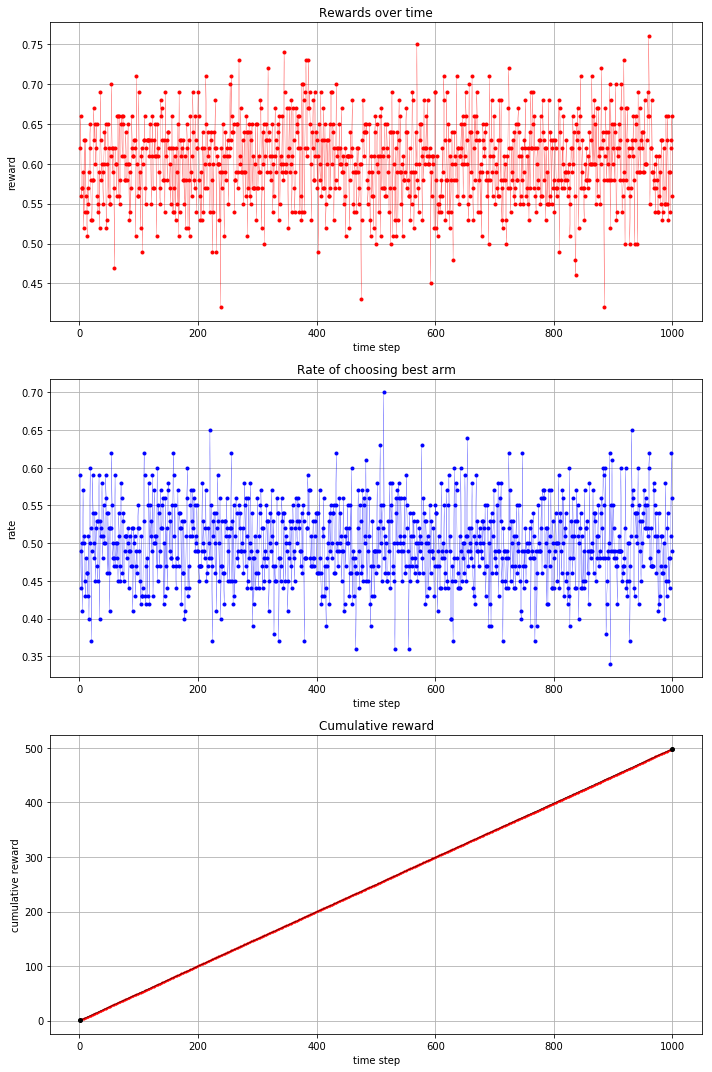

In [99]:
params = {"lr": 0.003}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)
#it [ H preferences ] [ softmax probs ]  sel.action last.action last.reward r_diff 

In [37]:
1+1*(5==5)

2

In [26]:
def greedyAction(q_estimate):
    # Choose greedly one of the best actions
    return randomArgmax(q_estimate)

def epsilonGreedyAction(q_estimate, eps):
    # Greedy action with prob p=1-eps, random with prob eps=1-p
    if np.random.choice([True, False], p=[1-eps, eps]):
        # Greedy action
        return greedyAction(q_estimate)
    else:
        # Random action
        return np.random.choice(np.arange(len(q_estimate)))

def upperConfidenceBoundAction(q_estimate, c, iteration, act_count):
    # De Sutton:
    # "if action a was never chosen > a is a maximizing action"
    # NO quiero que las acciones jamas elegidas 'me pisen' acciones con
    # pesos fuertes por tener peso infinito al dividir por cero.
    uncertainty = np.sqrt(np.log(iteration)/np.maximum(1, act_count))
    # Con 'maximizing action' de Sutton, elijo su valor a partir del maximo de las
    # acciones ya elegidas.
    # ie: Las acciones no elegidas tienen EL MISMO valor que LA MEJOR accion elegida hasta el momento,
    #     de esa forma evito que solo elija acciones NO tomadas hasta que las tome todas.
    # 1. q_estimate + uncertainty para acciones ya elegidas (ignoro las NO elegidas)
    part_candidates = q_estimate + c*np.where(act_count>0, uncertainty, 0)
    # 2. le doy el max puntaje (de q_estimate) a las acciones NO elegidas
    candidates = np.where(act_count>0, part_candidates, np.amax(part_candidates))
    return randomArgmax(candidates)

def gradientAction():
    pass

In [27]:
def randomArgmax(v):
    """Like np.argmax(), but if there are several "best" actions,
       chooses and returns one randomly"""
    arguments = np.argwhere(v == np.amax(v)).ravel()
    arg = np.random.choice(arguments)
    return arg

def softmax_vect(v):
    """Returns a vector with all softmax values"""
    exp_vect = np.exp(v)
    return exp_vect/np.sum(exp_vect)

## Gradient Bandits

Gradient bandits actualiza la preferencia de cada accion deacuerdo a 
la diferencia entre el reward obtenido y el promedio

<img src="img/gradient-bandits.png" width="500" align="left" />

In [14]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # función que realiza las simulaciones de los agentes. Se define el número de repeticiones que seran
    #  promediadas y el número de pasos N. agents es una lista de agentes.
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

### up

In [96]:
def plot_results(agents, actions, rewards):
    # Simulates and plot data
    # Number of steps to play
    N = 1000
    # We play for 'N' steps, then repeat for 'reps' times, and take the mean
    reps = 100
    # Generating data
    total_data = np.asarray(simulateBandits(agents, narms=actions, initp=rewards, initq=None, repetitions=reps, N=N))
    # data shape: (rewards, agents, time step)
    if len(agents)==1:
        # reshaping as several actor data
        total_data = total_data.reshape(2,1,N)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    # Subplot 1: Rewards over time
    ax1.set_title("Rewards over time")
    ax1.set_xlabel("time step")
    ax1.set_ylabel("reward")
    ax1.grid()
    # Subplot 2: Agent's rate of choosing best arm
    ax2.set_title("Rate of choosing best arm")
    ax2.set_xlabel("time step")
    ax2.set_ylabel("rate")
    ax2.grid()
    # Subplot 3: Cumulative reward
    ax3.set_title("Cumulative reward")
    ax3.set_xlabel("time step")
    ax3.set_ylabel("cumulative reward")
    ax3.grid()
    time_steps = np.arange(1, N+1)
    # looping over individual agent data
    for a in range(total_data.shape[-2]):
        # data from each agent
        data = total_data[:,a,:]
        # Subplot 1: Rewards over time
        ax1.plot(time_steps, data[0,:], 'r.-', label="reward-actor-"+str(a), linewidth=0.2)
        # Subplot 2: Agent's rate of choosing best arm
        ax2.plot(time_steps, data[1,:], 'b.-', label="best-arm-actor-"+str(a), linewidth=0.2)
        # Subplot 3: Cumulative reward
        ax3.plot(time_steps, np.cumsum(data[1,:]), 'r.', label="cumulative-actor-"+str(a), markersize=2, linewidth=0.5)
        # straight line for comparison
        ax3.plot([time_steps[0], time_steps[-1]],
                 [np.cumsum(data[1,:])[0], np.cumsum(data[1,:])[-1]],
                 'ko-', label="straight-line-"+str(a), markersize=4, linewidth=0.5)
    plt.tight_layout()
    plt.show()

[go down](#down)

# Ejercicios:

1) Completar pertinentemente el código donde diga "COMPLETAR".

[2)](#Bandits-de-2-brazos) Realizar simulaciones con un bandit de 2 brazos (P = [0.4, 0.8]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

[3)](#Bandits-de-10-brazos) Realizar simulaciones con un bandit de 10 brazos (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

4) Estudie la dependencia del hiperparametro epsilon en la regla de decisión epsilon-greedy.


## Bandits de 2 brazos

### Greedy

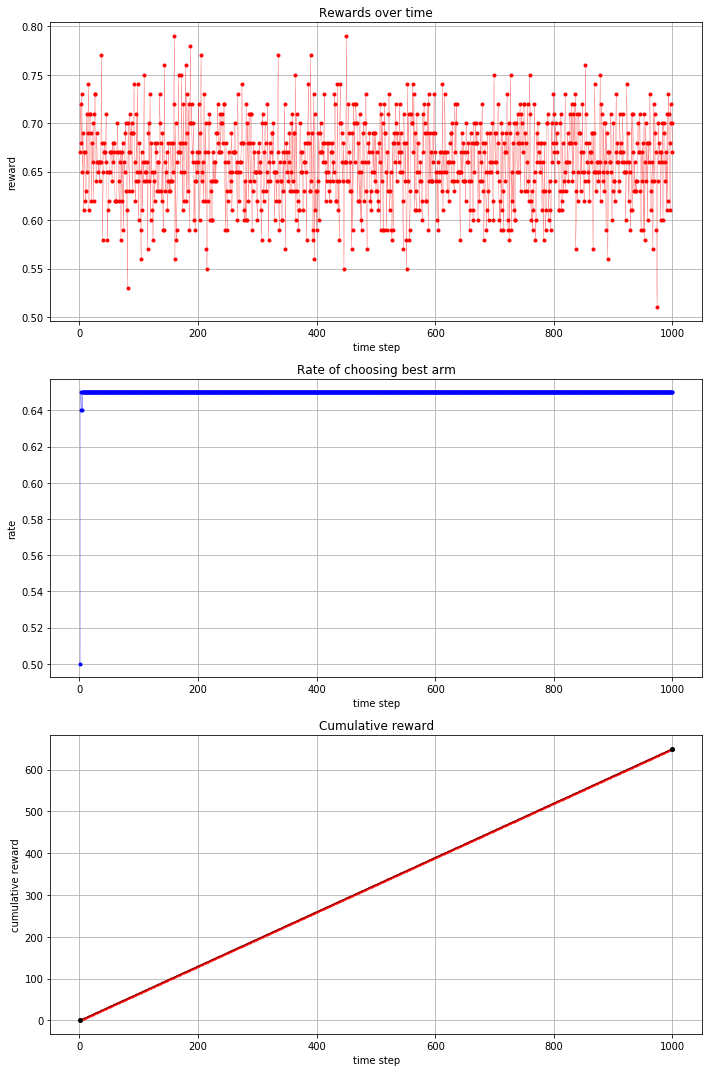

In [16]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

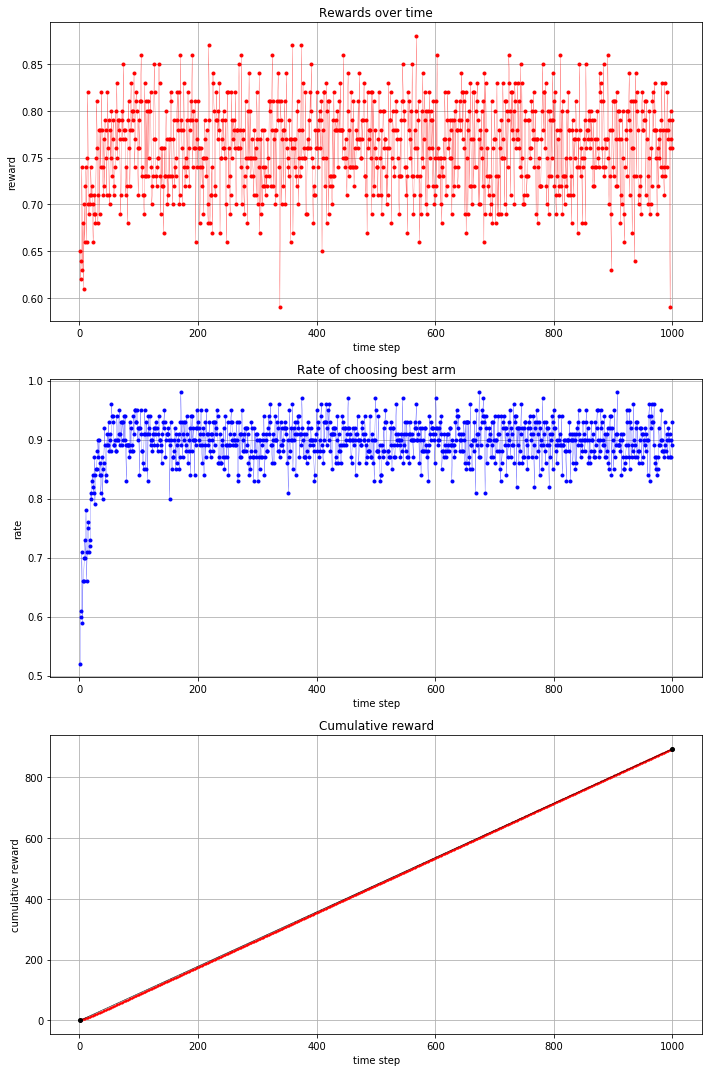

In [17]:
params = {"epsilon": 0.2}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### UCB

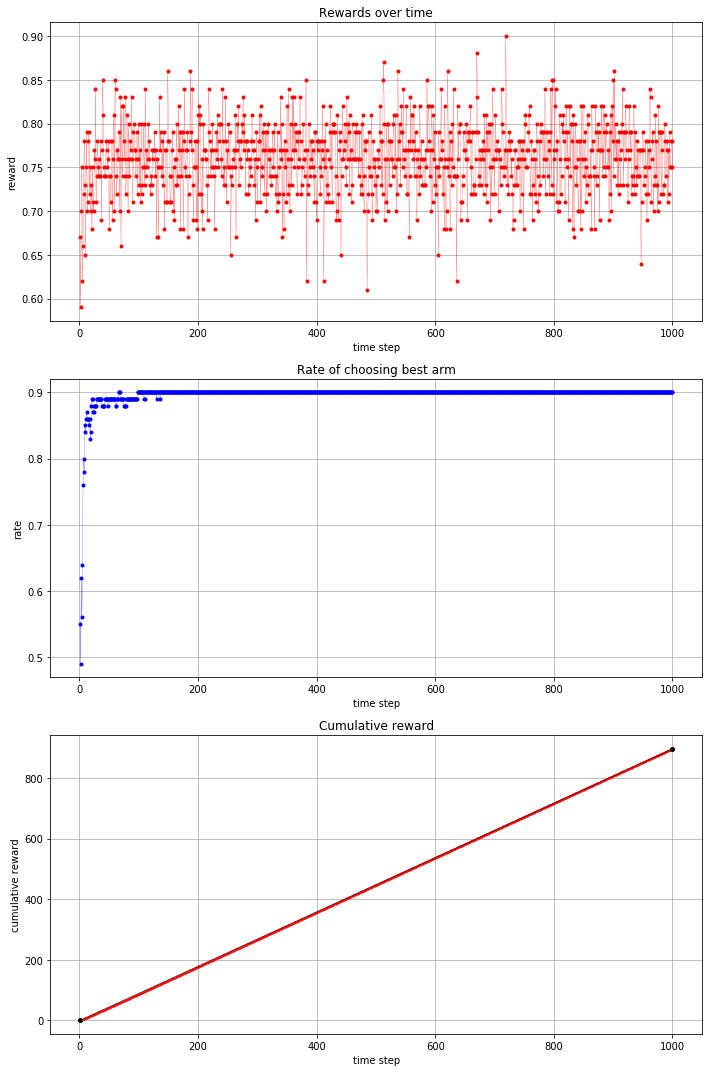

In [18]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

2 [0. 0.] [0.5 0.5] 1 0 0 0.0
3 [0. 0.] [0.5 0.5] 0 1 0 0.0
4 [ 0.025 -0.025] [0.5 0.5] 0 0 1 0.5
102 [-0.20453709  0.20453709] [0.40300641 0.59699359] 1 1 1 0.20000000000000007
103 [-0.17317655  0.17317655] [0.39913414 0.60086586] 1 1 0 -0.7857142857142857
104 [-0.18189796  0.18189796] [0.41426706 0.58573294] 0 1 1 0.21052631578947367
202 [ 0.16589498 -0.16589498] [0.59003029 0.40996971] 0 0 0 -0.3939393939393939
203 [ 0.14960058 -0.14960058] [0.58219484 0.41780516] 0 0 0 -0.38999999999999996
204 [ 0.13316062 -0.13316062] [0.57424722 0.42575278] 1 0 0 -0.3861386138613861
302 [ 0.3643563 -0.3643563] [0.68162897 0.31837103] 0 1 1 0.23880597014925342
303 [ 0.35098848 -0.35098848] [0.6745227 0.3254773] 1 0 0 -0.4107142857142856
304 [ 0.33513957 -0.33513957] [0.66862594 0.33137406] 0 1 1 0.2370370370370367
402 [ 0.36830236 -0.36830236] [0.65414311 0.34585689] 0 1 0 -0.7590361445783137
403 [ 0.38723333 -0.38723333] [0.67625296 0.32374704] 1 0 1 0.5847457627118644
404 [ 0.37083845 -0.3708384

902 [-1.0873431  1.0873431] [0.10057512 0.89942488] 1 1 0 -0.803600654664484
903 [-1.08934402  1.08934402] [0.10204682 0.89795318] 1 1 1 0.19607843137254943
904 [-1.09133451  1.09133451] [0.1016807 0.8983193] 0 1 1 0.19575856443719453
2 [0. 0.] [0.5 0.5] 1 1 1 0.0
3 [0. 0.] [0.5 0.5] 0 1 1 0.0
4 [0. 0.] [0.5 0.5] 0 0 1 0.0
102 [-0.28379227  0.28379227] [0.36511784 0.63488216] 1 1 1 0.19672131147540983
103 [-0.29079474  0.29079474] [0.36179436 0.63820564] 1 1 1 0.19354838709677424
104 [-0.29762459  0.29762459] [0.35856693 0.64143307] 1 1 1 0.19047619047619058
202 [-0.26078999  0.26078999] [0.38438398 0.61561602] 0 0 0 -0.41095890410958913
203 [-0.22432616  0.22432616] [0.37248285 0.62751715] 1 0 1 0.5810810810810809
204 [-0.23066981  0.23066981] [0.38968124 0.61031876] 1 1 1 0.16279069767441878
302 [-0.11812076  0.11812076] [0.45227791 0.54772209] 0 0 0 -0.4086956521739131
303 [-0.14076128  0.14076128] [0.44121278 0.55878722] 0 0 0 -0.40517241379310354
304 [-0.10715064  0.10715064] [0.4

902 [-0.90389492  0.90389492] [0.14153403 0.85846597] 1 1 1 0.18309859154929642
903 [-0.90647084  0.90647084] [0.14090546 0.85909454] 1 1 1 0.1828125000000006
904 [-0.90903139  0.90903139] [0.14028297 0.85971703] 1 1 1 0.1825273010920443
2 [0. 0.] [0.5 0.5] 0 1 1 0.0
3 [0. 0.] [0.5 0.5] 0 0 0 0.0
4 [0. 0.] [0.5 0.5] 0 0 0 0.0
102 [ 0.23277081 -0.23277081] [0.62056538 0.37943462] 0 1 1 0.2127659574468086
103 [ 0.21734393 -0.21734393] [0.61432798 0.38567202] 0 0 0 -0.4000000000000001
104 [ 0.2405033 -0.2405033] [0.60699253 0.39300747] 0 0 1 0.5892857142857142
202 [ 0.33683532 -0.33683532] [0.6391576 0.3608424] 0 1 0 -0.7976190476190478
203 [ 0.32224087 -0.32224087] [0.66232459 0.33767541] 0 0 0 -0.43220338983050854
204 [ 0.34162212 -0.34162212] [0.65576586 0.34423414] 1 0 1 0.5630252100840336
302 [ 0.27459925 -0.27459925] [0.62427296 0.37572704] 1 0 1 0.5519125683060109
303 [ 0.2634119 -0.2634119] [0.63394962 0.36605038] 1 1 1 0.17647058823529393
304 [ 0.31475917 -0.31475917] [0.62874201

902 [ 0.53581402 -0.53581402] [0.74853665 0.25146335] 0 0 0 -0.38166311300639655
903 [ 0.52609875 -0.52609875] [0.7449064 0.2550936] 0 0 0 -0.3808510638297872
904 [ 0.51626313 -0.51626313] [0.74119666 0.25880334] 0 0 0 -0.38004246284501053
2 [0. 0.] [0.5 0.5] 1 0 0 0.0
3 [0. 0.] [0.5 0.5] 0 1 0 0.0
4 [ 0.025 -0.025] [0.5 0.5] 0 0 1 0.5
102 [-0.25203684  0.25203684] [0.35966013 0.64033987] 0 0 1 0.5681818181818181
103 [-0.21740261  0.21740261] [0.37658382 0.62341618] 0 0 1 0.5555555555555556
104 [-0.24379481  0.24379481] [0.39297947 0.60702053] 1 0 0 -0.4347826086956522
202 [-0.38769219  0.38769219] [0.29869832 0.70130168] 1 0 1 0.5569620253164556
203 [-0.39384469  0.39384469] [0.31531551 0.68468449] 0 1 1 0.19512195121951226
204 [-0.35604127  0.35604127] [0.31266502 0.68733498] 1 0 1 0.5499999999999999
302 [-0.42919909  0.42919909] [0.30012536 0.69987464] 0 1 1 0.1948717948717955
303 [-0.38981633  0.38981633] [0.29767412 0.70232588] 1 0 1 0.5607476635514019
304 [-0.36463232  0.36463232

202 [-0.05868445  0.05868445] [0.45458275 0.54541725] 0 1 0 -0.7127659574468084
203 [-0.02682792  0.02682792] [0.47069141 0.52930859] 0 0 1 0.6018518518518517
204 [ 0.00378832 -0.00378832] [0.48658926 0.51341074] 1 0 1 0.5963302752293578
302 [-0.05300143  0.05300143] [0.47987586 0.52012414] 1 1 1 0.2653061224489798
303 [-0.01844697  0.01844697] [0.47352407 0.52647593] 1 1 0 -0.7297297297297295
304 [ 0.01712617 -0.01712617] [0.49077756 0.50922244] 1 1 0 -0.7248322147651004
402 [-0.37770223  0.37770223] [0.32293103 0.67706897] 1 1 1 0.23333333333333317
403 [-0.38512527  0.38512527] [0.31964484 0.68035516] 1 1 1 0.2322274881516586
404 [-0.39243886  0.39243886] [0.31642491 0.68357509] 0 1 1 0.231132075471698
502 [-0.72905748  0.72905748] [0.1900059 0.8099941] 1 1 1 0.2142857142857142
503 [-0.71427944  0.71427944] [0.18875581 0.81124419] 0 1 0 -0.7829181494661923
504 [-0.74589245  0.74589245] [0.19332333 0.80667667] 0 0 0 -0.391891891891892
602 [-0.70919044  0.70919044] [0.17976998 0.820230

102 [ 0.10812455 -0.10812455] [0.55736621 0.44263379] 1 1 1 0.1276595744680853
103 [ 0.10120139 -0.10120139] [0.55385258 0.44614742] 0 1 1 0.12500000000000022
104 [ 0.08567075 -0.08567075] [0.55042866 0.44957134] 1 0 0 -0.3454545454545455
202 [ 0.48997187 -0.48997187] [0.73319642 0.26680358] 1 1 1 0.21111111111111114
203 [ 0.47479072 -0.47479072] [0.72709705 0.27290295] 0 1 1 0.20879120879120883
204 [ 0.46507662 -0.46507662] [0.72103099 0.27896901] 0 0 0 -0.34821428571428575
302 [ 0.62031273 -0.62031273] [0.77850865 0.22149135] 0 0 0 -0.36956521739130443
303 [ 0.61206719 -0.61206719] [0.77567287 0.22432713] 1 0 0 -0.36756756756756764
304 [ 0.59503961 -0.59503961] [0.7727903 0.2272097] 0 1 1 0.22033898305084731
402 [ 0.28561585 -0.28561585] [0.64489273 0.35510727] 1 1 1 0.19718309859154937
403 [ 0.27310304 -0.27310304] [0.63904734 0.36095266] 1 1 1 0.19580419580419584
404 [ 0.26078975 -0.26078975] [0.63325492 0.36674508] 0 1 1 0.19444444444444442
502 [ 0.35177534 -0.35177534] [0.6742234

802 [-0.59033193  0.59033193] [0.23661952 0.76338048] 1 1 1 0.19780219780219788
803 [-0.59497046  0.59497046] [0.23493285 0.76506715] 1 1 1 0.19744058500914086
804 [-0.57628336  0.57628336] [0.2332695 0.7667305] 1 1 0 -0.8010948905109488
902 [-0.3126949  0.3126949] [0.36142667 0.63857333] 1 0 0 -0.44014084507042256
903 [-0.31951939  0.31951939] [0.34855662 0.65144338] 1 1 1 0.19579288025889985
904 [-0.29178182  0.29178182] [0.34546386 0.65453614] 0 1 0 -0.8029079159935378
2 [0. 0.] [0.5 0.5] 0 0 0 0.0
3 [0. 0.] [0.5 0.5] 1 0 0 0.0
4 [0. 0.] [0.5 0.5] 0 1 1 0.0
102 [ 0.00012851 -0.00012851] [0.50868298 0.49131702] 1 0 0 -0.3508771929824561
103 [-0.00542776  0.00542776] [0.50006425 0.49993575] 1 1 1 0.11111111111111127
104 [-0.01083305  0.01083305] [0.49728615 0.50271385] 0 1 1 0.1086956521739132
202 [ 0.32821988 -0.32821988] [0.66388691 0.33611309] 0 0 0 -0.36036036036036034
203 [ 0.34987107 -0.34987107] [0.65846018 0.34153982] 0 0 1 0.6339285714285714
204 [ 0.37072304 -0.37072304] [0.6

502 [-0.42900577  0.42900577] [0.30041304 0.69958696] 0 1 1 0.2110389610389618
503 [-0.4604982  0.4604982] [0.29775496 0.70224504] 0 0 0 -0.44845360824742264
504 [-0.49240913  0.49240913] [0.28475491 0.71524509] 1 0 0 -0.4461538461538461
602 [-0.56620332  0.56620332] [0.24553681 0.75446319] 1 1 1 0.20052083333333426
603 [-0.57107767  0.57107767] [0.24371724 0.75628276] 1 1 1 0.20000000000000095
604 [-0.57590363  0.57590363] [0.24192486 0.75807514] 1 1 1 0.19948186528497502
702 [-0.8056066  0.8056066] [0.1673888 0.8326112] 1 1 1 0.20806794055201816
703 [-0.80906194  0.80906194] [0.16642024 0.83357976] 1 1 1 0.20762711864406902
704 [-0.81249015  0.81249015] [0.16546377 0.83453623] 1 1 1 0.207188160676534
802 [-0.64914441  0.64914441] [0.22599517 0.77400483] 1 0 0 -0.4342629482071711
803 [-0.63233067  0.63233067] [0.21445314 0.78554686] 1 1 0 -0.7840290381125216
804 [-0.61509977  0.61509977] [0.22017251 0.77982749] 1 1 0 -0.7826086956521728
902 [-0.98078154  0.98078154] [0.12386262 0.8761

402 [ 0.20548541 -0.20548541] [0.6085721 0.3914279] 0 0 0 -0.3875968992248063
403 [ 0.22980639 -0.22980639] [0.60132064 0.39867936] 1 0 1 0.6100386100386099
404 [ 0.21490897 -0.21490897] [0.61292231 0.38707769] 0 1 1 0.2430555555555558
502 [ 0.15427494 -0.15427494] [0.58439939 0.41560061] 1 0 0 -0.38871473354231995
503 [ 0.19775107 -0.19775107] [0.57653126 0.42346874] 0 1 0 -0.7540983606557375
504 [ 0.18215832 -0.18215832] [0.59760652 0.40239348] 0 0 0 -0.3875000000000002
602 [ 0.34843383 -0.34843383] [0.67473028 0.32526972] 0 1 1 0.24299065420560761
603 [ 0.33497929 -0.33497929] [0.66749293 0.33250707] 0 0 0 -0.40463917525773235
604 [ 0.32131722 -0.32131722] [0.66149388 0.33850612] 0 0 0 -0.4035989717223654
702 [ 0.05251155 -0.05251155] [0.5117362 0.4882638] 1 0 1 0.5946547884187078
703 [ 0.04086373 -0.04086373] [0.52623167 0.47376833] 0 1 1 0.22134387351778684
704 [ 0.0214674 -0.0214674] [0.5204205 0.4795795] 0 0 0 -0.4044444444444449
802 [ 0.02916004 -0.02916004] [0.49967123 0.50032

302 [ 0.05165466 -0.05165466] [0.51126034 0.48873966] 0 0 1 0.5960264900662251
303 [ 0.03262444 -0.03262444] [0.52580438 0.47419562] 0 0 0 -0.40131578947368435
304 [ 0.01333992 -0.01333992] [0.51630643 0.48369357] 1 0 0 -0.3986928104575165
402 [ 0.29328045 -0.29328045] [0.64927867 0.35072133] 0 0 0 -0.4178403755868546
403 [ 0.31399102 -0.31399102] [0.64257567 0.35742433] 0 0 1 0.5794392523364484
404 [ 0.29942491 -0.29942491] [0.65203176 0.34796824] 0 0 0 -0.41860465116279083
502 [ 0.08826511 -0.08826511] [0.52213351 0.47786649] 0 1 0 -0.8421052631578951
503 [ 0.11539103 -0.11539103] [0.5440183 0.4559817] 0 0 1 0.594890510948905
504 [ 0.09752773 -0.09752773] [0.5574408 0.4425592] 1 0 0 -0.40363636363636374
602 [ 0.30058031 -0.30058031] [0.63597075 0.36402925] 1 0 1 0.5939393939393939
603 [ 0.28965663 -0.28965663] [0.64592179 0.35407821] 0 1 1 0.16911764705882326
604 [ 0.27511943 -0.27511943] [0.64090937 0.35909063] 0 0 0 -0.4048338368580061
702 [ 0.35500139 -0.35500139] [0.66142417 0.33

202 [ 0.01283571 -0.01283571] [0.51750801 0.48249199] 1 0 0 -0.46
203 [ 0.00141649 -0.00141649] [0.5064175 0.4935825] 1 1 1 0.22549019607843146
204 [-0.00976437  0.00976437] [0.50070824 0.49929176] 1 1 1 0.22330097087378653
302 [-0.03812235  0.03812235] [0.48748486 0.51251514] 1 1 1 0.26845637583892645
303 [-0.05094763  0.05094763] [0.48094806 0.51905194] 0 1 1 0.26666666666666694
304 [-0.07224045  0.07224045] [0.4745482 0.5254518] 0 0 0 -0.40522875816993476
402 [-0.36129711  0.36129711] [0.33048548 0.66951452] 1 1 1 0.25120772946859915
403 [-0.33694259  0.33694259] [0.32682197 0.67317803] 1 1 0 -0.7451923076923076
404 [-0.34550443  0.34550443] [0.33762743 0.66237257] 1 1 1 0.2535885167464116
502 [-0.42912607  0.42912607] [0.30071833 0.69928167] 0 1 1 0.23897058823529405
503 [-0.38637766  0.38637766] [0.29770465 0.70229535] 1 0 1 0.6086956521739131
504 [-0.39389869  0.39389869] [0.31588338 0.68411662] 0 1 1 0.23809523809523803
602 [-0.42538993  0.42538993] [0.30219956 0.69780044] 1 1 1

2 [0. 0.] [0.5 0.5] 0 1 1 0.0
3 [0. 0.] [0.5 0.5] 1 0 1 0.0
4 [0. 0.] [0.5 0.5] 1 1 1 0.0
102 [-0.18637712  0.18637712] [0.41107062 0.58892938] 1 1 1 0.1607142857142858
103 [-0.19281726  0.19281726] [0.40787567 0.59212433] 1 1 1 0.1578947368421053
104 [-0.19909816  0.19909816] [0.40476864 0.59523136] 1 1 1 0.15517241379310354
202 [ 0.06354886 -0.06354886] [0.54117394 0.45882606] 0 0 0 -0.4137931034482759
203 [ 0.04439244 -0.04439244] [0.53173173 0.46826827] 1 0 0 -0.4090909090909091
204 [ 0.08707511 -0.08707511] [0.52218165 0.47781835] 0 1 0 -0.817391304347826
302 [-0.01923314  0.01923314] [0.47475944 0.52524056] 1 0 1 0.5957446808510639
303 [ 0.02127689 -0.02127689] [0.49038462 0.50961538] 1 1 0 -0.8260869565217387
304 [ 0.06319955 -0.06319955] [0.51063684 0.48936316] 1 1 0 -0.8209876543209872
402 [ 0.16322105 -0.16322105] [0.56856465 0.43143535] 0 0 1 0.5846153846153845
403 [ 0.18759766 -0.18759766] [0.58089343 0.41910657] 0 0 1 0.5816326530612245
404 [ 0.17064462 -0.17064462] [0.592

302 [ 0.29284908 -0.29284908] [0.64831269 0.35168731] 0 1 1 0.19999999999999973
303 [ 0.27903989 -0.27903989] [0.6423775 0.3576225] 0 0 0 -0.3861386138613861
304 [ 0.30127388 -0.30127388] [0.63600812 0.36399188] 0 0 1 0.6108374384236454
402 [ 0.17059765 -0.17059765] [0.58975317 0.41024683] 0 1 1 0.1843971631205672
403 [ 0.15467738 -0.15467738] [0.58448085 0.41551915] 1 0 0 -0.3831417624521071
404 [ 0.14411758 -0.14411758] [0.57672776 0.42327224] 0 1 1 0.18309859154929564
502 [ 0.31109299 -0.31109299] [0.62771582 0.37228418] 0 1 0 -0.7945945945945945
503 [ 0.29787087 -0.29787087] [0.65071555 0.34928445] 1 0 0 -0.3785488958990535
504 [ 0.3488215 -0.3488215] [0.64468148 0.35531852] 0 1 0 -0.7903225806451611
602 [ 0.68795467 -0.68795467] [0.80078532 0.19921468] 0 0 0 -0.3840206185567009
603 [ 0.68023016 -0.68023016] [0.79833322 0.20166678] 0 0 0 -0.3830334190231361
604 [ 0.67242999 -0.67242999] [0.7958345 0.2041655] 0 0 0 -0.3820512820512819
702 [ 0.76855151 -0.76855151] [0.82855995 0.1714

202 [-0.20369412  0.20369412] [0.40310673 0.59689327] 0 1 1 0.18421052631578905
203 [-0.22962314  0.22962314] [0.39953854 0.60046146] 1 0 0 -0.43181818181818177
204 [-0.2366931  0.2366931] [0.38716464 0.61283536] 1 1 1 0.18260869565217352
302 [-0.37605456  0.37605456] [0.3233462 0.6766538] 1 1 1 0.2114285714285712
303 [-0.38278944  0.38278944] [0.32036191 0.67963809] 1 1 1 0.21022727272727249
304 [-0.38942512  0.38942512] [0.31743626 0.68256374] 1 1 1 0.2090395480225986
402 [-0.27985273  0.27985273] [0.37518401 0.62481599] 1 0 0 -0.3974358974358974
403 [-0.25132516  0.25132516] [0.36361561 0.63638439] 1 1 0 -0.7845528455284555
404 [-0.25941288  0.25941288] [0.37691804 0.62308196] 1 1 1 0.2145748987854249
502 [-0.31875409  0.31875409] [0.3570576 0.6429424] 1 0 0 -0.38378378378378364
503 [-0.32649937  0.32649937] [0.34581003 0.65418997] 1 1 1 0.22397476340693978
504 [-0.33414223  0.33414223] [0.3423141 0.6576859] 1 1 1 0.22327044025157206
602 [-0.0742869  0.0742869] [0.46839839 0.5316016

2 [0. 0.] [0.5 0.5] 1 0 1 0.0
3 [0. 0.] [0.5 0.5] 0 1 1 0.0
4 [-0.025  0.025] [0.5 0.5] 0 0 0 -0.5
102 [ 0.08445483 -0.08445483] [0.52234087 0.47765913] 0 1 0 -0.7608695652173914
103 [ 0.11388951 -0.11388951] [0.54212731 0.45787269] 0 0 1 0.642857142857143
104 [ 0.09833512 -0.09833512] [0.55669982 0.44330018] 0 0 0 -0.35087719298245607
202 [-0.02234938  0.02234938] [0.49284354 0.50715646] 1 1 1 0.1630434782608694
203 [-0.03023369  0.03023369] [0.48882717 0.51117283] 0 1 1 0.16129032258064502
204 [-0.04990161  0.04990161] [0.48488776 0.51511224] 0 0 0 -0.38181818181818183
302 [ 0.14116844 -0.14116844] [0.57831549 0.42168451] 1 0 0 -0.39751552795031053
303 [ 0.13146429 -0.13146429] [0.57011905 0.42988095] 0 1 1 0.1702127659574466
304 [ 0.15748926 -0.15748926] [0.56535606 0.43464394] 1 0 1 0.5987654320987654
402 [ 0.45348938 -0.45348938] [0.7170962 0.2829038] 1 0 0 -0.40869565217391307
403 [ 0.4398216 -0.4398216] [0.71238153 0.28761847] 0 1 1 0.19186046511627852
404 [ 0.42788841 -0.427888

402 [-0.02385839  0.02385839] [0.4986128 0.5013872] 1 0 0 -0.4205128205128204
403 [-0.03187505  0.03187505] [0.48807307 0.51192693] 1 1 1 0.16425120772946866
404 [ 0.00838637 -0.00838637] [0.48406787 0.51593213] 1 1 0 -0.8317307692307692
502 [ 0.07853374 -0.07853374] [0.5252178 0.4747822] 0 0 1 0.5909090909090908
503 [ 0.10565158 -0.10565158] [0.53918634 0.46081366] 1 0 1 0.5884773662551439
504 [ 0.09544917 -0.09544917] [0.55263011 0.44736989] 1 1 1 0.18461538461538474
602 [ 0.27890837 -0.27890837] [0.61271312 0.38728688] 0 1 0 -0.8085808580858085
603 [ 0.26368877 -0.26368877] [0.63594722 0.36405278] 1 0 0 -0.41806020066889643
604 [ 0.25169057 -0.25169057] [0.62887126 0.37112874] 0 1 1 0.19078947368421062
702 [ 0.00767927 -0.00767927] [0.50842054 0.49157946] 0 1 1 0.1802325581395351
703 [ 0.03664506 -0.03664506] [0.50383956 0.49616044] 1 0 1 0.5837988826815641
704 [ 0.02733043 -0.02733043] [0.51831433 0.48168567] 1 1 1 0.17971014492753645
802 [ 0.01417801 -0.01417801] [0.51708392 0.482

102 [ 0.12449765 -0.12449765] [0.56739883 0.43260117] 0 1 1 0.1960784313725492
103 [ 0.10731841 -0.10731841] [0.5619292 0.4380708] 0 0 0 -0.392156862745098
104 [ 0.13393941 -0.13393941] [0.55345415 0.44654585] 0 0 1 0.5961538461538463
202 [ 0.17816161 -0.17816161] [0.59309498 0.40690502] 0 1 1 0.17241379310344862
203 [ 0.16025509 -0.16025509] [0.5881501 0.4118499] 0 0 0 -0.4347826086956523
204 [ 0.18382047 -0.18382047] [0.57944858 0.42055142] 1 0 1 0.5603448275862069
302 [ 0.30561047 -0.30561047] [0.65533848 0.34466152] 0 0 0 -0.45505617977528107
303 [ 0.28969191 -0.28969191] [0.64821927 0.35178073] 1 0 0 -0.4525139664804471
304 [ 0.27832064 -0.27832064] [0.64092561 0.35907439] 1 1 1 0.17741935483870974
402 [ 0.00542506 -0.00542506] [0.50716898 0.49283102] 0 1 1 0.1757575757575759
403 [-0.01576736  0.01576736] [0.5027125 0.4972875] 1 0 0 -0.42616033755274274
404 [ 0.02455065 -0.02455065] [0.49211697 0.50788303] 0 1 0 -0.8192771084337348
502 [ 0.16301031 -0.16301031] [0.56875619 0.43124

102 [-0.23853115  0.23853115] [0.38789344 0.61210656] 1 1 1 0.2692307692307694
103 [-0.21107464  0.21107464] [0.38294606 0.61705394] 0 1 0 -0.7169811320754715
104 [-0.22919456  0.22919456] [0.39600256 0.60399744] 1 0 0 -0.29999999999999993
202 [-0.10783775  0.10783775] [0.45566458 0.54433542] 1 0 0 -0.3478260869565218
203 [-0.11879212  0.11879212] [0.44628917 0.55371083] 0 1 1 0.2454545454545456
204 [-0.1380306  0.1380306] [0.44088176 0.55911824] 1 0 0 -0.34408602150537637
302 [-0.02086082  0.02086082] [0.47342118 0.52657882] 1 0 1 0.6142857142857143
303 [-0.03234458  0.03234458] [0.4895711 0.5104289] 1 1 1 0.23456790123456783
304 [-0.04362413  0.04362413] [0.48383335 0.51616665] 1 1 1 0.2331288343558282
402 [ 0.00526098 -0.00526098] [0.50874431 0.49125569] 1 1 1 0.2403846153846153
403 [-0.00676367  0.00676367] [0.50263047 0.49736953] 1 1 1 0.23923444976076547
404 [-0.01858791  0.01858791] [0.49661822 0.50338178] 0 1 1 0.23809523809523803
502 [ 0.34454539 -0.34454539] [0.67159639 0.328

202 [-0.46054528  0.46054528] [0.28764874 0.71235126] 1 1 1 0.24786324786324831
203 [-0.46754302  0.46754302] [0.28473574 0.71526426] 1 1 1 0.24576271186440724
204 [-0.4744127  0.4744127] [0.28189401 0.71810599] 1 1 1 0.2436974789915971
302 [-0.39238903  0.39238903] [0.2960267 0.7039733] 1 0 1 0.5789473684210527
303 [-0.39955473  0.39955473] [0.31329102 0.68670898] 1 1 1 0.22872340425531923
304 [-0.40661255  0.40661255] [0.31021605 0.68978395] 1 1 1 0.22751322751322756
402 [-0.26108769  0.26108769] [0.37626787 0.62373213] 1 1 1 0.2226562500000001
403 [-0.2322564  0.2322564] [0.3723437 0.6276563] 1 1 0 -0.7743190661478598
404 [-0.20249003  0.20249003] [0.38591581 0.61408419] 1 1 0 -0.7713178294573643
502 [-0.44621027  0.44621027] [0.29333845 0.70666155] 1 1 1 0.22492401215805513
503 [-0.45272699  0.45272699] [0.29061057 0.70938943] 1 1 1 0.2242424242424247
504 [-0.45916412  0.45916412] [0.28793099 0.71206901] 0 1 1 0.22356495468277993
602 [-0.20747553  0.20747553] [0.38096749 0.61903251

902 [-0.49481875  0.49481875] [0.27342262 0.72657738] 0 1 1 0.2251308900523562
903 [-0.52650292  0.52650292] [0.27098369 0.72901631] 1 0 0 -0.43461538461538446
904 [-0.53231069  0.53231069] [0.25864832 0.74135168] 1 1 1 0.22454308093994801
2 [0. 0.] [0.5 0.5] 0 0 0 0.0
3 [0. 0.] [0.5 0.5] 0 0 0 0.0
4 [ 0.03333333 -0.03333333] [0.5 0.5] 0 0 1 0.6666666666666667
102 [ 0.03071392 -0.03071392] [0.51888583 0.48111417] 0 1 1 0.13636363636363658
103 [ 0.05661751 -0.05661751] [0.51535213 0.48464787] 0 0 1 0.5344827586206895
104 [ 0.03503026 -0.03503026] [0.52827855 0.47172145] 1 0 0 -0.4576271186440679
202 [-0.21448859  0.21448859] [0.39788807 0.60211193] 0 1 1 0.18478260869565222
203 [-0.23651148  0.23651148] [0.3943706 0.6056294] 0 0 0 -0.3636363636363636
204 [-0.25871324  0.25871324] [0.383901 0.616099] 1 0 0 -0.3603603603603603
302 [-0.02041938  0.02041938] [0.49925944 0.50074056] 0 0 0 -0.3782051282051282
303 [ 0.01110304 -0.01110304] [0.48979173 0.51020827] 0 0 1 0.6178343949044587
304 [

202 [-0.06861652  0.06861652] [0.47062797 0.52937203] 0 1 1 0.20833333333333348
203 [-0.0897851  0.0897851] [0.46574548 0.53425452] 1 0 0 -0.3962264150943398
204 [-0.09917123  0.09917123] [0.4552277 0.5447723] 0 1 1 0.20618556701030943
302 [-0.44386452  0.44386452] [0.27289248 0.72710752] 1 0 1 0.6344827586206895
303 [-0.41990678  0.41990678] [0.2915787 0.7084213] 1 1 0 -0.821656050955414
304 [-0.42525113  0.42525113] [0.30157405 0.69842595] 0 1 1 0.17721518987341767
402 [-0.31269024  0.31269024] [0.35946633 0.64053367] 1 0 0 -0.372340425531915
403 [-0.3188796  0.3188796] [0.34855873 0.65144127] 0 1 1 0.1775700934579436
404 [-0.34311097  0.34311097] [0.34575325 0.65424675] 1 0 0 -0.37037037037037046
502 [-0.29168585  0.29168585] [0.3610674 0.6389326] 0 1 1 0.17499999999999982
503 [-0.31568268  0.31568268] [0.35815714 0.64184286] 1 0 0 -0.37387387387387394
504 [-0.32173707  0.32173707] [0.34720101 0.65279899] 1 1 1 0.17437722419928803
602 [-0.2297467  0.2297467] [0.39017824 0.60982176] 

702 [ 0.68708587 -0.68708587] [0.79381034 0.20618966] 0 0 1 0.6334841628959276
703 [ 0.67970091 -0.67970091] [0.79805332 0.20194668] 0 0 0 -0.36568848758465017
704 [ 0.67224535 -0.67224535] [0.79566246 0.20433754] 1 0 0 -0.3648648648648649
802 [ 0.83637287 -0.83637287] [0.84350798 0.15649202] 0 0 0 -0.37760910815939286
803 [ 0.84619166 -0.84619166] [0.84194156 0.15805844] 0 0 1 0.6212121212121211
804 [ 0.84031405 -0.84031405] [0.84453733 0.15546267] 0 0 0 -0.37807183364839325
902 [ 0.82321783 -0.82321783] [0.83565872 0.16434128] 0 0 1 0.6133768352365416
903 [ 0.83311332 -0.83311332] [0.83840874 0.16159126] 1 0 1 0.6123778501628665
904 [ 0.81477853 -0.81477853] [0.84107209 0.15892791] 0 1 1 0.21799307958477554
2 [0. 0.] [0.5 0.5] 1 1 1 0.0
3 [0. 0.] [0.5 0.5] 1 1 1 0.0
4 [0. 0.] [0.5 0.5] 1 1 1 0.0
102 [ 0.18645441 -0.18645441] [0.59734464 0.40265536] 0 1 1 0.17999999999999994
103 [ 0.16998401 -0.16998401] [0.59216166 0.40783834] 0 0 0 -0.40384615384615385
104 [ 0.1943054 -0.1943054] [0

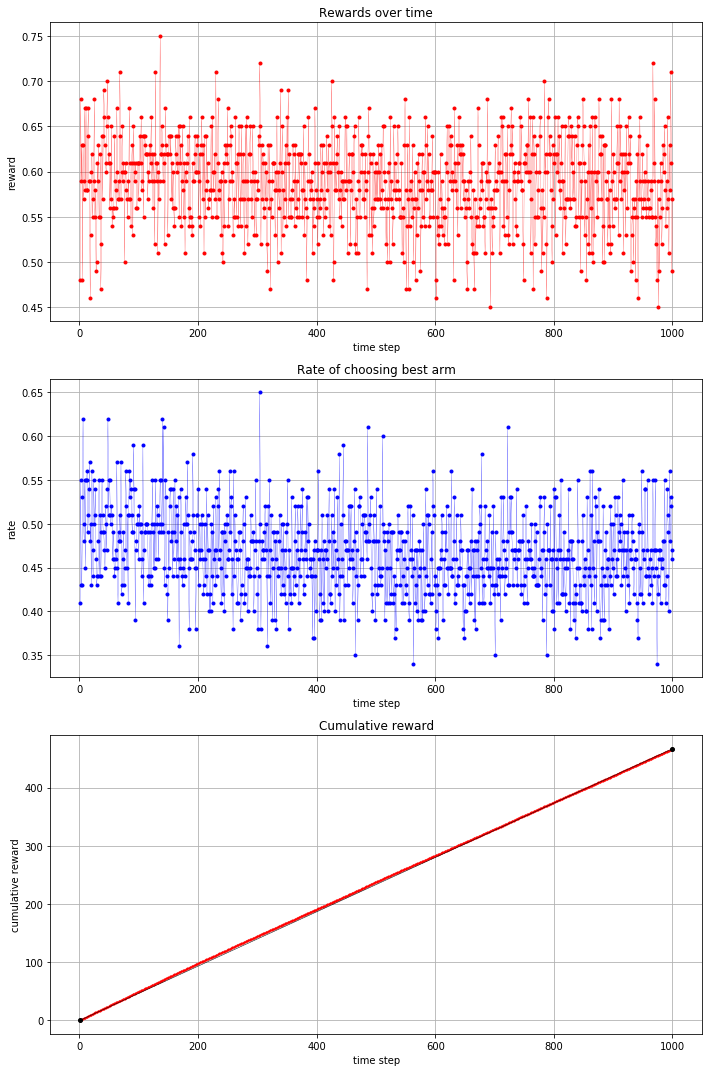

In [70]:
params = {"lr": 0.1}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Bandits de 10 brazos

#### Greedy

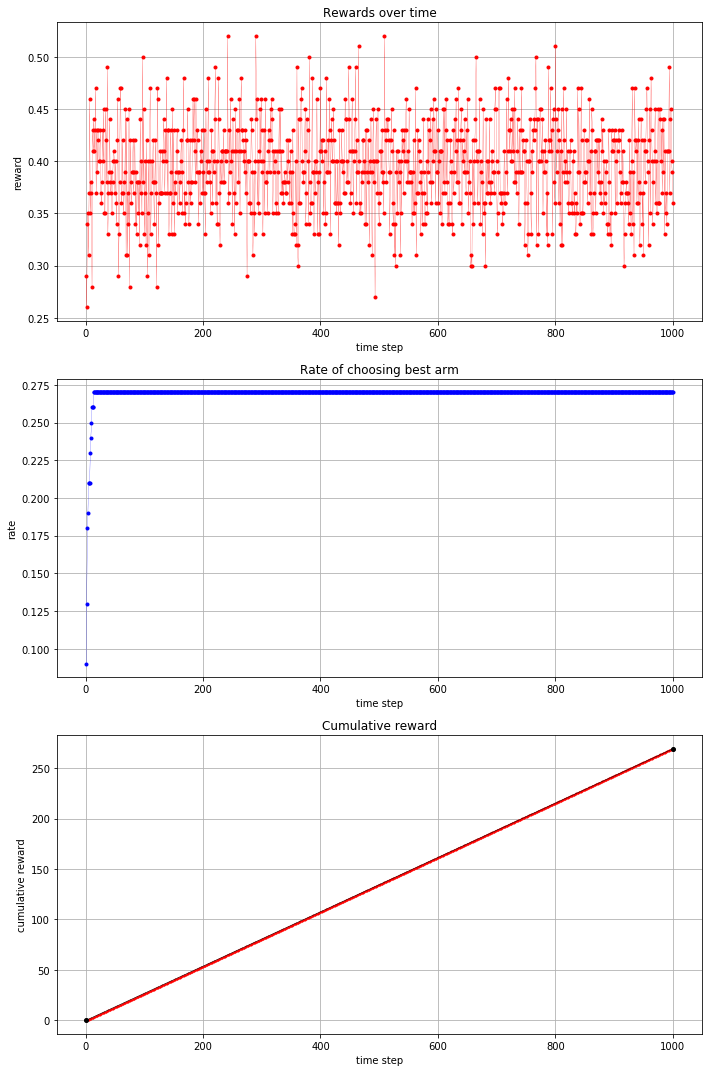

In [20]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

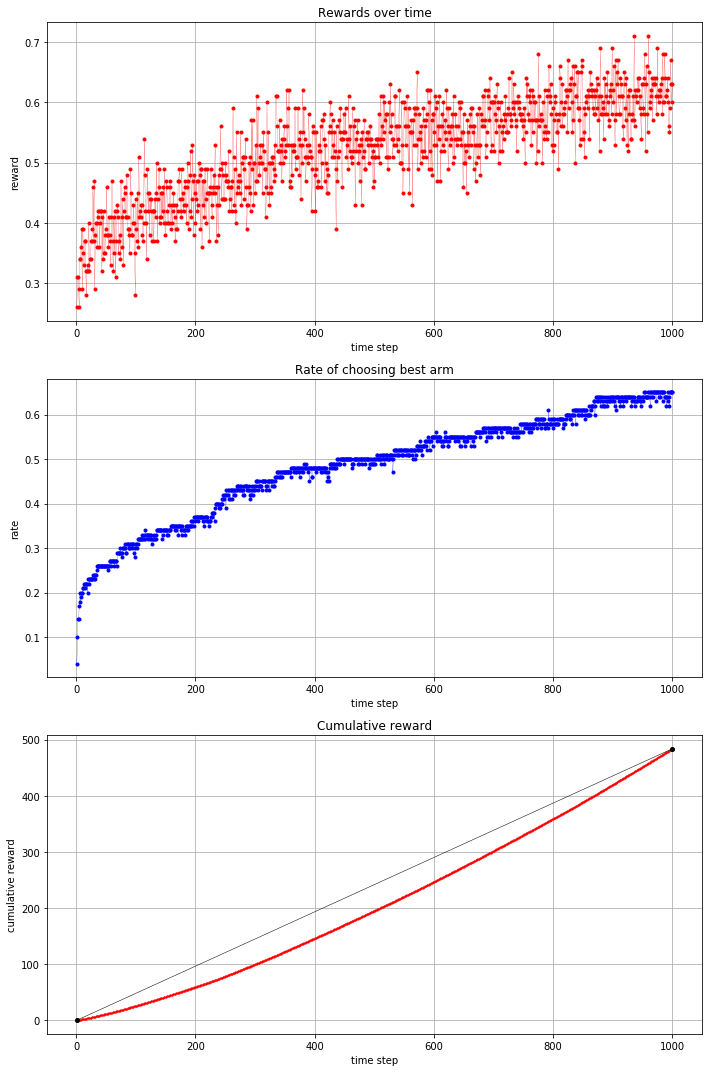

In [450]:
params = {"epsilon": 0.01}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### UCB

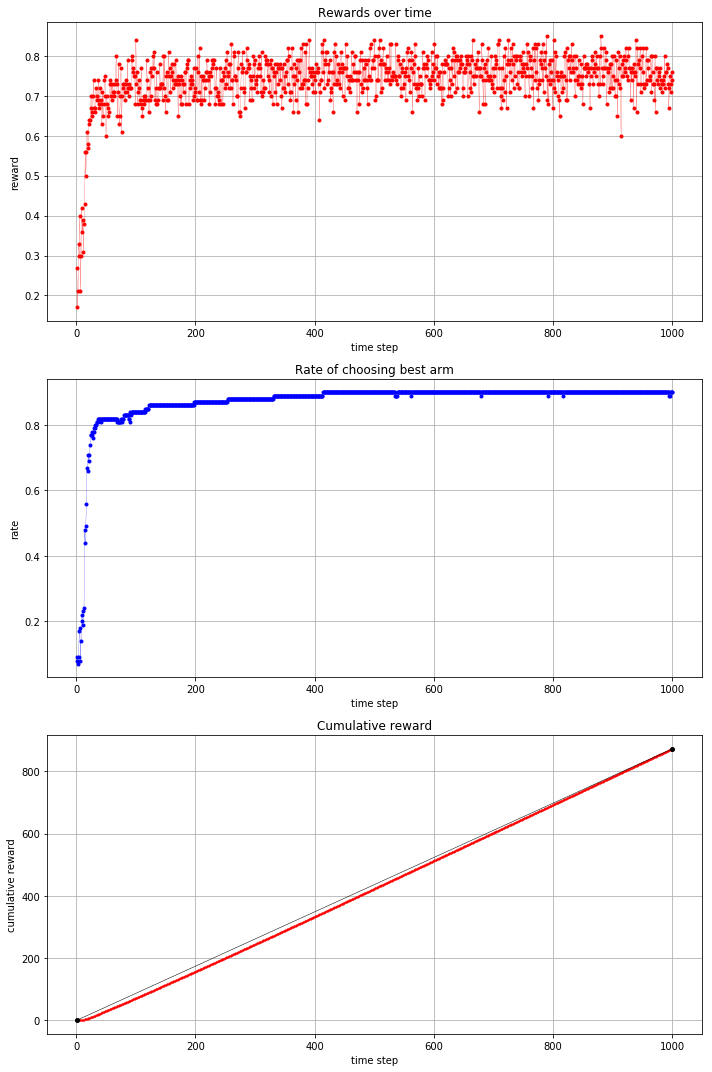

In [451]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 9 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 0 6 1 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 0 0 0.0
102 [ 0.01339882 -0.00895896 -0.01384925 -0.00112883  0.00356213  0.01135956
 -0.00512049 -0.00180318 -0.00296771  0.0055079 ] [0.10134554 0.09910482 0.09862135 0.09988387 0.10035352 0.10113908
 0.09948596 0.09981653 0.09970036 0.10054897] 8 0 0 -0.23076923076923075
103 [ 0.01363728 -0.00872577 -0.0136172  -0.00089381  0.00379825  0.01159754
 -0.0048864  -0.00156832 -0.00508606  0.00574448] [0.10136961 0.09912783 0.09864414 0.09990725 0.10037712 0.10116305
 0.09950915 0.09983988 0.09948929 0.10057267] 8 8 0 -0.23529411764705888
104 [ 0.01290517 -0.00944169 -0.01432963 -0.00161537  0.00307331  0.01086692
 -0.00560508 -0.00228938  0.00141763  0.00501813] [0.10129556 0.09905703 0.09857403 0.09983532 0.10030452 0.10108931
 0.0994378  0.

102 [-0.0008632   0.00536526  0.02269866 -0.00585077 -0.02390014  0.00288169
  0.00195937  0.01606406 -0.0014551  -0.01689983] [0.09990519 0.10052939 0.10228709 0.09940815 0.09762999 0.10028002
 0.10018758 0.1016107  0.09984607 0.09831582] 1 4 0 -0.375
103 [-0.00161248  0.01211129  0.02193151 -0.00659633 -0.02463236  0.00212959
  0.00120797  0.01530198 -0.00220395 -0.0176372 ] [0.09982972 0.10120921 0.102208   0.09933342 0.0975579  0.10020399
 0.10011168 0.10153265 0.09977069 0.09824273] 5 1 1 0.75
104 [-0.00147938  0.01224623  0.02206779 -0.00646388 -0.02450229  0.00092986
  0.00134145  0.01543735 -0.00207092 -0.01750621] [0.09984303 0.10122288 0.10222195 0.0993466  0.09757061 0.10008386
 0.10012506 0.10154641 0.09978398 0.09825561] 1 5 0 -0.13333333333333336
202 [-0.00720026  0.01125138  0.02514959 -0.02050447 -0.0285009   0.00855221
 -0.00221328  0.03084996  0.00316153 -0.02054575] [0.09926515 0.10111376 0.10252887 0.09795325 0.0971731  0.1008412
 0.09976142 0.10311499 0.10029906 0.

202 [ 0.00333831 -0.03141766 -0.00680239 -0.00271458  0.0146567  -0.00849834
 -0.00271458  0.01362131  0.00154542  0.01898581] [0.10032492 0.09689793 0.09931269 0.09971949 0.10146688 0.09914441
 0.09971949 0.10136188 0.10014521 0.1019071 ] 4 1 0 -0.08695652173913042
203 [ 0.00343386 -0.03132538 -0.00670781 -0.00261961  0.01380095 -0.00840392
 -0.00261961  0.01371785  0.0016408   0.01908287] [0.10033464 0.096907   0.09932222 0.0997291  0.10138023 0.0991539
 0.0997291  0.1013718  0.10015489 0.10191712] 6 4 0 -0.09523809523809523
204 [ 0.00252173 -0.03220635 -0.00761073 -0.00352624  0.01287931 -0.00930531
  0.00556467  0.01279628  0.0007303   0.01815635] [0.10024305 0.09682156 0.09923247 0.09963861 0.10128672 0.09906446
 0.10054855 0.10127831 0.10006363 0.10182263] 5 6 1 0.9090909090909091
302 [ 0.03223695 -0.02492035 -0.02593524  0.00057603  0.01524898 -0.00588796
  0.01360595  0.01080623 -0.02690158  0.01117098] [0.10325687 0.09752049 0.09742156 0.10003888 0.10151756 0.09939431
 0.10135

302 [-0.0216702  -0.01145076  0.00794208  0.00222245 -0.01017309 -0.00964211
  0.02686399 -0.00213353  0.00960743  0.00843374] [0.09784769 0.09885277 0.10078851 0.10021369 0.09897915 0.09903172
 0.10271378 0.09977811 0.1009565  0.10083808] 9 5 0 -0.11764705882352944
303 [-0.02137369 -0.0111512   0.0082475   0.00252612 -0.00987316 -0.00934202
  0.02717525 -0.00183117  0.00991336  0.00570901] [0.09787691 0.09888259 0.10081951 0.10024433 0.09900905 0.09906165
 0.10274597 0.09980849 0.1009876  0.1005639 ] 3 9 0 -0.30303030303030304
304 [-0.02220746 -0.01199354  0.00738867  0.01019071 -0.01071657 -0.01018587
  0.0263     -0.00268139  0.0090531   0.00485235] [0.09779483 0.09879882 0.10073243 0.10101509 0.09892506 0.09897757
 0.10265555 0.09972314 0.10090024 0.10047727] 4 3 1 0.8518518518518519
402 [-0.03421514 -0.01137135  0.01238219  0.03458718 -0.00796645 -0.00084136
  0.02140969 -0.00562925 -0.01099315  0.00263764] [0.09662025 0.09885282 0.10122904 0.10350197 0.09918998 0.09989924
 0.1021

302 [-0.00369426  0.01906389  0.02587198 -0.00230405  0.03918483  0.02145086
 -0.03802097 -0.02822776 -0.00257178 -0.03075274] [0.09960019 0.10189289 0.10258896 0.09973875 0.10396384 0.1021364
 0.09623926 0.09718638 0.09971205 0.09694129] 6 2 1 0.6363636363636362
303 [-0.00350751  0.01925494  0.02606433 -0.00211704  0.03937977  0.02164237
 -0.03971552 -0.02804553 -0.00238482 -0.03057098] [0.09961806 0.10191162 0.10260794 0.09975667 0.10398335 0.10215521
 0.09607561 0.09720338 0.09972996 0.0969582 ] 0 6 0 -0.18750000000000006
304 [-0.00742222  0.01969803  0.02651045 -0.00168332  0.03983187  0.02208652
 -0.0392978  -0.02762291 -0.00195121 -0.03014942] [0.09922857 0.1019565  0.10265344 0.09979967 0.10403008 0.10220031
 0.09611548 0.0972442  0.09977294 0.09699882] 3 0 0 -0.4347826086956521
402 [-0.0396525   0.01786541  0.02772528  0.00097238  0.06054148  0.00613915
 -0.04189546  0.00016456  0.00113458 -0.03299487] [0.09606797 0.1017556  0.10276386 0.10005108 0.10619212 0.10056936
 0.095852

502 [-0.03247518 -0.00485198  0.02848786  0.03809769  0.03994132  0.00037791
 -0.06225624 -0.02676991  0.03681522 -0.01736668] [0.0967507  0.09946052 0.10283241 0.10382538 0.10401697 0.09998205
 0.09391184 0.09730427 0.10369231 0.09822356] 3 6 0 -0.24999999999999994
503 [-0.03325264 -0.00565122  0.02766153  0.04529909  0.03910547 -0.00042551
 -0.06301089 -0.02755182  0.03598197 -0.01815598] [0.09667233 0.09937779 0.1027441  0.10457233 0.10392665 0.09989847
 0.09383792 0.09722502 0.10360254 0.09814284] 8 3 1 0.8035714285714286
504 [-0.03308848 -0.00548246  0.027836    0.04547667  0.03928195 -0.00025587
 -0.06285154 -0.02738672  0.03445979 -0.01798932] [0.09668876 0.09939514 0.10276262 0.10459151 0.10394559 0.099916
 0.09385341 0.09724164 0.10344556 0.09815976] 8 8 0 -0.16981132075471697
602 [-0.03395585  0.003017    0.04057878  0.06823782  0.03469127  0.00409008
 -0.05923311 -0.04131005  0.02411666 -0.04023261] [0.09658355 0.10022136 0.10405744 0.10697575 0.10344661 0.10032896
 0.094172

802 [-0.06113954 -0.01621132  0.01575218 -0.04456409  0.0333433   0.06510978
  0.02650107 -0.01027988  0.04626011 -0.05477161] [0.09398686 0.09830582 0.10149877 0.09555772 0.10330005 0.1066342
 0.10259566 0.09889065 0.10464301 0.09458727] 3 4 0 -0.22093023255813962
803 [-0.06094051 -0.01600315  0.01596712 -0.04647938  0.03356205  0.06533559
  0.02671833 -0.01007046  0.0464817  -0.05457131] [0.09400463 0.0983253  0.10151958 0.09537392 0.10332162 0.10665722
 0.10261693 0.09891037 0.10466516 0.09460528] 0 3 0 -0.21176470588235305
804 [-0.06286816 -0.01579394  0.01618312 -0.04627645  0.03378189  0.06556252
  0.02693667 -0.00986002  0.0467044  -0.05437002] [0.09382235 0.09834457 0.10154016 0.09539201 0.10334295 0.10668001
 0.10263797 0.09892987 0.10468707 0.09462306] 4 0 0 -0.2127659574468085
902 [-0.04367251 -0.00442248  0.00946622 -0.05016453  0.04510729  0.06703426
  0.03092034 -0.02966457  0.03354683 -0.05815084] [0.09564344 0.0994721  0.10086328 0.09502454 0.10452298 0.10684017
 0.1030

902 [ 0.04906285 -0.02185021  0.04930878  0.02504172 -0.00566377  0.00994698
 -0.06573972 -0.06211817 -0.01918082  0.04119236] [0.10494336 0.09775924 0.10496918 0.10245254 0.09935449 0.10091766
 0.09356143 0.09390088 0.09802055 0.10412065] 5 8 0 -0.1744186046511628
903 [ 0.04925064 -0.02167527  0.04949662  0.02522506 -0.00548598  0.00833809
 -0.06557229 -0.06195014 -0.01900541  0.04137868] [0.1049632  0.09777647 0.10498902 0.10247145 0.09937228 0.10075555
 0.09357721 0.09391678 0.09803786 0.10414018] 4 5 0 -0.1789473684210526
904 [ 0.04948493 -0.02145702  0.04973097  0.02545379 -0.00749631  0.00856299
 -0.06536342 -0.0617405  -0.01878658  0.04161113] [0.10498759 0.09779761 0.10501342 0.10249469 0.09917251 0.10077801
 0.09359657 0.09393628 0.09805913 0.10416418] 2 4 0 -0.2232142857142858
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 4 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 3 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 

802 [-0.0557332  -0.00978495  0.05543774 -0.01368296  0.02321243  0.03280729
 -0.00327998  0.02065759  0.02163466 -0.07126863] [0.09451315 0.09895718 0.10562656 0.09857219 0.10227697 0.10326303
 0.09960299 0.10201601 0.10211573 0.09305619] 6 5 0 -0.2
803 [-0.05552982 -0.009572    0.05566504 -0.01347084  0.02343252  0.0330295
 -0.00521754  0.02087712  0.02185441 -0.07106838] [0.09453224 0.09897812 0.10565043 0.09859297 0.10229935 0.10328584
 0.09941005 0.10203827 0.10213804 0.0930747 ] 4 6 0 -0.21518987341772156
804 [-0.05530203 -0.0093335   0.05591962 -0.01323327  0.02126939  0.03327838
 -0.004978    0.021123    0.02210052 -0.07084411] [0.09455425 0.09900221 0.10567785 0.09861688 0.1020788  0.10331206
 0.09943436 0.10206386 0.10216368 0.09309604] 5 4 0 -0.2409638554216868
902 [-0.06235    -0.00934176  0.05621001  0.00095101  0.00767738  0.02383906
 -0.02200654  0.03157107  0.0451982  -0.07174844] [0.09387872 0.09898932 0.10569565 0.10001345 0.10068845 0.10232896
 0.09774355 0.10312324 

902 [-0.06435278  0.06431127  0.01408832  0.02178499  0.01694188 -0.01317302
  0.00839686 -0.0465399  -0.0179044   0.01644678] [0.09371019 0.10657735 0.10135691 0.10214003 0.10164655 0.09863111
 0.10078168 0.0953944  0.09816555 0.10159624] 7 9 0 -0.11702127659574468
903 [-0.06452512  0.06411527  0.01390192  0.02159715  0.01675494 -0.01335441
  0.00821152 -0.04487626 -0.01808493  0.01625994] [0.09369484 0.10655737 0.10133888 0.10212172 0.10162842 0.09861406
 0.10076386 0.09555405 0.09814867 0.10157813] 7 7 1 0.18390804597701138
904 [-0.06469548  0.06392153  0.01371766  0.02141147  0.01657016 -0.01353371
  0.00802831 -0.04323181 -0.01826338  0.01607525] [0.09367965 0.1065376  0.10132104 0.10210359 0.10161047 0.09859719
 0.10074623 0.09571209 0.09813195 0.1015602 ] 8 7 1 0.18181818181818166
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 8 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 6 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0.

102 [ 0.00800586  0.01150376 -0.01015443  0.01729671  0.00582151 -0.00677777
 -0.00576942 -0.01398761 -0.00964409  0.00370548] [0.10079868 0.10115188 0.09898467 0.10173955 0.10057874 0.09931947
 0.09941967 0.09860597 0.0990352  0.10036614] 9 2 0 -0.14285714285714288
103 [ 0.00724987  0.01074512 -0.01089681  0.01653366  0.00506717 -0.00752267
 -0.00651507 -0.01472716 -0.01038685  0.01045273] [0.10072199 0.10107465 0.0989107  0.10166142 0.10050238 0.099245
 0.09934505 0.09853256 0.09896115 0.1010451 ] 8 9 1 0.75
104 [ 0.00664554  0.01013867 -0.01149028  0.01592369  0.00446416 -0.00811814
 -0.00711114 -0.01531835 -0.00498062  0.00984646] [0.10066161 0.10101385 0.09885248 0.10159991 0.10044226 0.09918639
 0.09928632 0.09847479 0.09949807 0.10098433] 4 8 1 0.6
202 [ 0.00116423  0.01583067  0.0030357   0.01434116  0.01516719 -0.02566989
 -0.01747423  0.00160349 -0.01554284  0.00754451] [0.10010669 0.10158572 0.10029422 0.10143452 0.10151834 0.09745614
 0.09825814 0.10015068 0.0984481  0.1007

102 [-0.00076602 -0.00493357 -0.01410359  0.00189526  0.00442862  0.00425455
 -0.0119087  -0.00020747  0.00344445  0.01789647] [0.09991973 0.09950418 0.09859589 0.100186   0.10044013 0.10042265
 0.09881254 0.09997556 0.10034133 0.10180199] 9 8 0 -0.5714285714285714
103 [-5.99484999e-04 -4.76772954e-03 -1.39392672e-02  2.06224051e-03
  4.59602326e-03  4.42191628e-03 -1.17440153e-02 -4.08472048e-05
  3.61168678e-03  1.63994774e-02] [0.09993666 0.09952097 0.09861238 0.10020302 0.10045723 0.10043974
 0.0988291  0.0999925  0.1003584  0.10165   ] 5 9 0 -0.16666666666666666
104 [-0.00134901 -0.00551414 -0.01467886  0.00131072  0.00384259  0.01116862
 -0.01248523 -0.00079079  0.002859    0.0156371 ] [0.0998612  0.09944614 0.0985389  0.10012716 0.10038099 0.10111909
 0.0987553  0.09991696 0.10028231 0.10157195] 6 5 1 0.75
202 [ 0.01555103 -0.02754924 -0.0059945   0.00790125  0.00073122  0.000436
 -0.00903687  0.00483233 -0.00459137  0.01772013] [0.10155946 0.09727521 0.09939471 0.10078551 0.100

202 [ 0.00107209 -0.01799122 -0.03257083  0.01215931  0.03532375  0.01773365
  0.00107209  0.00616942  0.00023236 -0.02320061] [0.10008888 0.09819893 0.09677761 0.10120477 0.10357648 0.10177049
 0.10008888 0.10060037 0.10000487 0.0976887 ] 7 4 1 0.7692307692307692
203 [ 8.61372300e-04 -1.81979562e-02 -3.27745697e-02  1.19462450e-02
  3.51056933e-02  1.75193944e-02  8.61372300e-04  8.06289525e-03
  2.18277847e-05 -2.34062746e-02] [0.10006766 0.0981785  0.09675776 0.10118307 0.10355375 0.10174855
 0.10006766 0.1007909  0.09998368 0.09766848] 8 7 1 0.21052631578947378
204 [ 0.00102815 -0.01803433 -0.03261331  0.01211488  0.03527828  0.01768898
  0.00102815  0.00823088 -0.0014782  -0.02324349] [0.10008433 0.09819454 0.09677335 0.10120011 0.10357161 0.10176578
 0.10008433 0.10080781 0.09983379 0.09768436] 0 8 0 -0.16666666666666663
302 [ 0.00819172 -0.00356158 -0.05540371  0.01331497  0.02126158  0.01203609
  0.03343804 -0.00070086 -0.00615916 -0.02241709] [0.10079461 0.09961688 0.09458411 

 -0.00697229  0.04965968  0.03641138 -0.00336864] [0.09737149 0.09542188 0.09967676 0.09608748 0.10446215 0.09942061
 0.09925433 0.10503751 0.10365512 0.09961266] 5 5 0 -0.17857142857142855
402 [-0.0215361  -0.04690587 -0.00375354 -0.03966245  0.0160767  -0.00782104
  0.00914471  0.04953295  0.02841191  0.01651273] [0.09782939 0.0953787  0.09958461 0.09607208 0.10157911 0.09918037
 0.1008774  0.10503505 0.10283987 0.10162341] 4 8 0 -0.10638297872340428
403 [-0.02124525 -0.04662232 -0.00345748 -0.03937683  0.01340572 -0.00752618
  0.00944462  0.04984521  0.02871765  0.01681486] [0.09785825 0.09540614 0.0996145  0.09609991 0.10130856 0.09921002
 0.10090807 0.10506828 0.10287173 0.10165453] 2 4 0 -0.2972972972972972
404 [-0.02093497 -0.04631981 -0.00631236 -0.03907212  0.01372694 -0.00721161
  0.00976457  0.05017836  0.02904383  0.01713718] [0.09788843 0.09543482 0.09933033 0.09612901 0.10134092 0.09924105
 0.10094016 0.10510309 0.10290509 0.1016871 ] 7 2 0 -0.3170731707317073
502 [-0.027

402 [ 0.01905414 -0.02312529  0.01337969 -0.00163363 -0.0454588   0.01116562
 -0.03022326  0.0303943   0.01028985  0.01615738] [0.10189594 0.09768741 0.10131937 0.09980959 0.09552989 0.10109529
 0.09699648 0.10305803 0.1010068  0.1016012 ] 4 3 0 -0.20000000000000007
403 [ 0.01918422 -0.02300058  0.01350903 -0.00150621 -0.04661344  0.01129468
 -0.03009944  0.03052587  0.0104188   0.01628709] [0.1019086  0.09769902 0.10133189 0.09982173 0.09541909 0.10110775
 0.09700792 0.10307099 0.10101923 0.10161378] 1 4 0 -0.12765957446808512
404 [ 0.01937702 -0.02470764  0.01370074 -0.00131736 -0.04643292  0.01148596
 -0.02991591  0.03072087  0.01060991  0.01647933] [0.10192778 0.09753193 0.10135085 0.09984012 0.09543588 0.10112663
 0.09702528 0.10309061 0.10103807 0.10163285] 4 1 0 -0.1891891891891892
502 [ 0.00273953 -0.00500466  0.00990941  0.00479748 -0.04254251  0.0051368
 -0.04051589  0.03620094  0.0232638   0.00601507] [0.1002468  0.09947347 0.10096814 0.10045331 0.09580866 0.1004874
 0.09600

 0.09759746 0.09788159 0.0964285  0.10313922] 2 0 0 -0.29729729729729726
502 [ 0.02204381 -0.04765619  0.02400908  0.01780551  0.02150732  0.02180572
 -0.0212289  -0.03043509 -0.03306655  0.02521529] [0.10218973 0.09530967 0.10239076 0.10175754 0.10213492 0.10216541
 0.09786202 0.09696522 0.09671039 0.10251434] 5 5 1 0.8103448275862069
503 [ 0.02223433 -0.04747849  0.02419998  0.01799523  0.02169774  0.02013179
 -0.02104645 -0.0302543  -0.03288624  0.02540641] [0.10220959 0.09532696 0.10241069 0.10177723 0.10215476 0.10199491
 0.09788024 0.09698311 0.09672819 0.10253432] 4 5 0 -0.18644067796610175
504 [ 0.02238035 -0.04734231  0.02434628  0.01814063  0.0204151   0.0202775
 -0.02090662 -0.03011576 -0.03274806  0.02555289] [0.10222481 0.09534022 0.10242597 0.10179232 0.10202411 0.10201007
 0.09789421 0.09699683 0.09674184 0.10254963] 1 4 0 -0.14285714285714288
602 [ 0.04639649 -0.06785183  0.02855793  0.01975082  0.02989543  0.01112371
 -0.03707145 -0.02417001 -0.01847442  0.01184333] [0

602 [ 0.03165835  0.00876053  0.0400531   0.02621838  0.01644051  0.01595906
 -0.01379937 -0.01236392 -0.04725684 -0.06566979] [0.10316131 0.10082598 0.10403096 0.10260163 0.1016033  0.10155439
 0.09857682 0.09871842 0.09533325 0.09359394] 6 0 0 -0.25423728813559326
603 [ 0.0308524   0.00797283  0.03924035  0.0254168   0.01564674  0.01516566
 -0.006757   -0.01313516 -0.04800163 -0.066401  ] [0.10307915 0.10074751 0.10394741 0.10252037 0.10152362 0.10147479
 0.0992744  0.09864322 0.09526315 0.0935264 ] 5 6 1 0.7812499999999999
604 [ 0.03100273  0.00811975  0.03939194  0.02556631  0.01579479  0.01385531
 -0.00661223 -0.01299131 -0.0478627  -0.0662646 ] [0.10309484 0.10076251 0.10396336 0.10253589 0.10153884 0.1013421
 0.09928896 0.0986576  0.09527657 0.09353933] 2 5 0 -0.14583333333333337
702 [ 7.49839546e-03  2.13876226e-05  5.53157095e-02  2.53758293e-02
  3.15370972e-02  1.88058027e-02 -1.17812728e-02 -4.52195290e-03
 -4.72567472e-02 -7.49942490e-02] [0.10068707 0.09993704 0.10561863 

502 [ 0.02016018 -0.06496943 -0.02485201 -0.00687109  0.0150358   0.06917561
 -0.00591307  0.00016437  0.01298497 -0.01491532] [0.10198166 0.09365927 0.09749302 0.09926189 0.1014604  0.10710487
 0.09935703 0.09996271 0.10125254 0.09846661] 6 7 1 0.14814814814814825
503 [ 0.02032706 -0.06481617 -0.02469247 -0.00670867  0.01520183  0.06935087
 -0.00738685  0.00032794  0.01315065 -0.0147542 ] [0.10199854 0.0936735  0.09750845 0.09927788 0.10147711 0.1071235
 0.09921058 0.09997892 0.10126918 0.09848234] 8 6 0 -0.16363636363636366
504 [ 0.02048398 -0.06467206 -0.02454246 -0.00655593  0.01535795  0.06951568
 -0.00723422  0.00048176  0.01176799 -0.01460269] [0.10201472 0.09368715 0.09752324 0.09929321 0.10149313 0.10714133
 0.09922589 0.09999447 0.10112943 0.09849743] 8 8 0 -0.15384615384615385
602 [-0.00398267 -0.07757942 -0.01376003  0.00895314  0.03154664  0.06512476
  0.00380108 -0.00028276 -0.00426239 -0.00955835] [0.09954472 0.09248164 0.09857617 0.10084077 0.10314505 0.10666727
 0.1003

702 [-0.06603271 -0.01632501  0.00199441  0.01252343  0.05199428 -0.09518947
  0.00707424  0.05124365  0.03758329  0.01513387] [0.09351368 0.0982795  0.10009651 0.101156   0.10522856 0.09082649
 0.10060628 0.1051496  0.10372298 0.1014204 ] 0 7 1 0.21739130434782594
703 [-0.06808741 -0.01610224  0.0022213   0.01275272  0.0522328  -0.09498359
  0.00730228  0.05148199  0.0378184   0.01536375] [0.0933203  0.09829988 0.10011769 0.10117764 0.10525204 0.09084379
 0.10062768 0.10517305 0.10374578 0.10144216] 0 0 0 -0.2266666666666666
704 [-0.07011551 -0.01588236  0.00244524  0.01297904  0.05246823 -0.09478039
  0.00752737  0.05171725  0.03805046  0.01559067] [0.09312977 0.09831996 0.10013855 0.10119896 0.10527518 0.09086084
 0.10064876 0.10519615 0.10376824 0.1014636 ] 5 0 0 -0.22368421052631574
802 [-0.06891596  0.0066036   0.00695781  0.00166503  0.05816367 -0.09125687
  0.00563069  0.04768657  0.026486    0.00697947] [0.09325022 0.10056517 0.1006008  0.10006974 0.10588632 0.09119002
 0.1004

902 [ 0.01061049 -0.00663181  0.04938944 -0.06161594 -0.03333543  0.04398043
  0.01328474  0.04714814 -0.04527045 -0.0175596 ] [0.10099509 0.09926863 0.10498851 0.09395778 0.09665288 0.10442216
 0.10126554 0.10475346 0.09550619 0.09818975] 9 4 0 -0.19230769230769232
903 [ 0.01080471 -0.00644091  0.04959134 -0.06143525 -0.03314956  0.04418124
  0.01347949  0.04734959 -0.04508678 -0.01929385] [0.10101432 0.0992872  0.1050093  0.09397439 0.09667047 0.10444272
 0.10128487 0.10477416 0.09552335 0.09801923] 9 9 0 -0.19230769230769235
904 [ 0.01099712 -0.00625179  0.04979135 -0.06125625 -0.03296543  0.04438018
  0.01367241  0.04754916 -0.04490483 -0.02101191] [0.10103333 0.09930556 0.10502986 0.09399082 0.09668787 0.10446306
 0.10130399 0.10479463 0.09554033 0.09785056] 8 9 0 -0.19047619047619052
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 7 9 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 9 7 1 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 

902 [ 0.04421433  0.02252996 -0.0347535  -0.01602747 -0.03183781  0.04341811
  0.01337599 -0.02206757 -0.00235731 -0.01649474] [0.10447989 0.1022387  0.09654669 0.09837166 0.09682861 0.10439673
 0.10130708 0.09777928 0.09972565 0.09832571] 0 0 0 -0.24999999999999997
903 [ 0.05085527  0.02177179 -0.03546946 -0.01675696 -0.03255586  0.04264394
  0.01262472 -0.02279267 -0.00309685 -0.0172239 ] [0.10517234 0.10215761 0.0964742  0.09829647 0.0967557  0.10431227
 0.10122743 0.09770497 0.09964842 0.09825058] 1 0 1 0.7415730337078652
904 [ 0.05107355  0.01990834 -0.03526923 -0.01655295 -0.03235505  0.04286043
  0.01283482 -0.02258989 -0.00289003 -0.01701998] [0.10519573 0.10196785 0.09649391 0.09831693 0.09677553 0.10433529
 0.10124912 0.09772518 0.09966944 0.09827102] 4 1 0 -0.20754716981132076
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 7 9 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 2 7 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0.

 -0.00986303 -0.04731348  0.00720111  0.00389963] [0.09778404 0.09526173 0.1061359  0.10008107 0.10019625 0.10525818
 0.09896147 0.09532386 0.10066465 0.10033286] 4 1 0 -0.1886792452830189
702 [-0.03906427 -0.04771663  0.06749793 -0.01010155  0.01514733  0.05974671
 -0.00301384 -0.05418059  0.02390629 -0.01222138] [0.09609202 0.09526418 0.10689729 0.0989158  0.10144511 0.10607191
 0.09961938 0.09465039 0.10233757 0.09870634] 2 1 0 -0.2028985507246377
703 [-0.03863117 -0.04728727  0.06347268 -0.00965573  0.01560455  0.06022478
 -0.00256486 -0.053754    0.02436753 -0.0117765 ] [0.09613647 0.0953079  0.106471   0.09896282 0.10149449 0.10612575
 0.09966705 0.09469356 0.10238779 0.09875317] 8 2 0 -0.45070422535211274
704 [-0.03936422 -0.048014    0.06266084 -0.01041032  0.01483065  0.05941557
 -0.00332482 -0.05447603  0.03121183 -0.0125295 ] [0.09606414 0.09523679 0.1063825  0.09888623 0.10141398 0.10603782
 0.09958937 0.09462335 0.10308894 0.09867689] 9 8 1 0.7625
802 [-0.02113374 -0.06392

902 [-0.00842129  0.05112785 -0.04563547 -0.00620803  0.05052111  0.00491563
  0.02411402 -0.03959719  0.02391307 -0.05472971] [0.09909654 0.1051769  0.09547652 0.09931611 0.1051131  0.10042704
 0.1023737  0.09605478 0.10235313 0.09461217] 0 0 0 -0.24038461538461536
903 [-0.0105663   0.05137827 -0.04540815 -0.00597156  0.05077137  0.00515474
  0.02435777 -0.03936848  0.02415677 -0.05450444] [0.09888394 0.10520296 0.09549797 0.09933933 0.10513913 0.10045078
 0.10239838 0.09607649 0.1023778  0.09463323] 0 0 0 -0.23809523809523808
904 [-0.01269158  0.05162639 -0.04518292 -0.00573727  0.05101934  0.00539165
  0.02459928 -0.03914189  0.02439823 -0.05428125] [0.09867369 0.10522873 0.09551918 0.09936229 0.10516487 0.10047426
 0.10242279 0.09609796 0.1024022  0.09465405] 9 0 0 -0.23584905660377356
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 0 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 5 4 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 

102 [ 0.01236728 -0.00179121 -0.01229296  0.00225858 -0.00300521  0.00826214
 -0.01385905 -0.00475959  0.00032032  0.01249971] [0.10124056 0.09981724 0.09877447 0.1002223  0.09969614 0.1008258
 0.0986199  0.09952139 0.10002823 0.10125396] 1 1 0 -0.14285714285714285
103 [ 0.01250226 -0.00299145 -0.01216126  0.00239221 -0.00287228  0.00839657
 -0.01372756 -0.0046269   0.00045369  0.01263472] [0.10125419 0.09969748 0.09878745 0.10023566 0.09970936 0.10083932
 0.09863284 0.09953456 0.10004154 0.1012676 ] 3 1 0 -0.13333333333333333
104 [ 0.01279156 -0.0027066  -0.01187901 -0.00017854 -0.0025874   0.00868469
 -0.01344575 -0.00434251  0.00073952  0.01292405] [0.10128352 0.09972591 0.09881536 0.09997834 0.0997378  0.10086841
 0.09866067 0.0995629  0.10007017 0.10129694] 3 3 0 -0.28571428571428575
202 [ 0.01315842  0.0223083  -0.00892975 -0.0173093   0.00086109  0.00499379
 -0.01887083  0.00182804 -0.00463289  0.00659313] [0.10131694 0.10224823 0.09910356 0.09827659 0.10007864 0.10049309
 0.098

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 5 9 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 5 1 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 6 0 0.0
102 [ 0.01700461 -0.00232898 -0.00010465  0.00616089 -0.02853211 -0.00553079
  0.0017106  -0.00618347  0.01028573  0.00751818] [0.10170801 0.09976051 0.09998266 0.10061107 0.09718043 0.09944161
 0.10016432 0.09937673 0.10102694 0.10074772] 0 8 0 -0.07692307692307693
103 [ 0.02149607 -0.00282779 -0.00060456  0.00565784 -0.02901802 -0.006028
  0.00120978 -0.00668036  0.0097806   0.00701444] [0.10216487 0.09970981 0.09993173 0.10055951 0.09713228 0.09939122
 0.10011321 0.09932641 0.10097495 0.10069602] 3 0 1 0.5
104 [ 0.02190473 -0.00242895 -0.00020484  0.00206008 -0.02862949 -0.00563044
  0.00161023 -0.00628305  0.0101845   0.00741723] [0.10220678 0.09974973 0.09997183 0.10019851 0.09717017 0.09943089
 0.10015345 0.09936602 0.10101588

102 [-0.01459523  0.01200465  0.0067651   0.00774353  0.0003079  -0.00412544
 -0.01479114  0.00127045 -0.00141316  0.00683334] [0.09854739 0.10120392 0.10067504 0.10077359 0.10002705 0.09958458
 0.09852809 0.10012338 0.09985505 0.10068191] 0 2 0 -0.18181818181818182
103 [-0.01699911  0.01227453  0.00703357  0.00801226  0.00057464 -0.00385988
 -0.0145284   0.00153745 -0.00114688  0.00710182] [0.09831037 0.10123081 0.10070165 0.10080025 0.10005332 0.09961061
 0.09855356 0.1001497  0.09988122 0.10070852] 8 0 0 -0.2666666666666667
104 [-0.01675333  0.0125276   0.00728532  0.00826426  0.00082477 -0.00361086
 -0.01428201  0.00178782 -0.00339717  0.00735359] [0.09833447 0.10125637 0.10072694 0.1008256  0.10007829 0.09963536
 0.09857779 0.10017471 0.09965665 0.10073382] 4 8 0 -0.25000000000000006
202 [-0.02661959  0.03538143  0.03102164  0.0132216  -0.00781616 -0.01057933
 -0.02346     0.01246144 -0.02003386 -0.00357716] [0.09735173 0.10357868 0.10312808 0.10130864 0.09919959 0.09892586
 0.097

302 [-0.02105496  0.01416637  0.03413299 -0.00326157  0.00283596 -0.00275457
 -0.0204477  -0.00273167 -0.04190355  0.04101869] [0.09788858 0.10139779 0.1034427  0.09964594 0.10025539 0.09969648
 0.09794805 0.09969876 0.09586887 0.10415744] 8 2 1 0.6551724137931034
303 [-0.0217703   0.01342539  0.03337706 -0.00398975  0.00210333 -0.00348312
 -0.02116347 -0.00346023 -0.03529644  0.04025754] [0.09782135 0.10132554 0.10336746 0.09957622 0.1001848  0.09962668
 0.09788073 0.09962896 0.09650711 0.10408113] 4 8 1 0.7307692307692307
304 [-0.0216691   0.01353021  0.03348399 -0.00388674  0.00117248 -0.00338006
 -0.02106221 -0.00335717 -0.0351966   0.04036521] [0.09783126 0.10133618 0.10337852 0.09958649 0.1000916  0.09963696
 0.09789065 0.09963924 0.09651676 0.10409235] 9 4 0 -0.10344827586206899
402 [-0.01092834  0.01031693  0.02275905 -0.0042062   0.02498299 -0.00762298
 -0.02235007  0.01047316 -0.04093669  0.01751214] [0.09889324 0.10101673 0.10228144 0.09956025 0.10250916 0.09922066
 0.097770

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 9 2 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 9 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 4 0 0.0
102 [ 0.01658056  0.00052059 -0.00762424  0.00052059  0.00306384 -0.01774868
 -0.0031699   0.00445936  0.00807444 -0.00467658] [0.10166794 0.1000482  0.09923663 0.1000482  0.10030297 0.09823698
 0.09967965 0.10044304 0.10080681 0.09952958] 4 6 0 -0.3076923076923077
103 [ 0.01668223  0.00062064 -0.007525    0.00062064  0.00216415 -0.01765045
 -0.00307022  0.0045598   0.00817525 -0.00457705] [0.1016783  0.10005823 0.0992465  0.10005823 0.10021279 0.09824666
 0.09968961 0.10045316 0.100817   0.09953951] 2 4 0 -0.10000000000000002
104 [ 0.01722452  0.00115429 -0.01232902  0.00115429  0.00269861 -0.01712646
 -0.00253854  0.00509555  0.00871294 -0.00404617] [0.10173291 0.10011111 0.09877034 0.10011111 0.10026583 0.09829763
 0.0997421  0.1

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 5 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 8 4 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 9 8 0 0.0
102 [ 0.01502591 -0.0257726  -0.01770785  0.00285492  0.00370969 -0.00781654
  0.00907869  0.00285492  0.00994682  0.00782604] [0.10150616 0.09744821 0.09823728 0.10027822 0.10036397 0.0992138
 0.10090428 0.10027822 0.10099191 0.10077796] 1 6 0 -0.1111111111111111
103 [ 0.01521047 -0.0274136  -0.01752924  0.00303725  0.00389217 -0.00763615
  0.00926215  0.00303725  0.01013044  0.00800927] [0.10152441 0.09728796 0.09825435 0.10029602 0.1003818  0.09923122
 0.1009223  0.10029602 0.10100997 0.10079594] 5 1 0 -0.18181818181818185
104 [ 0.01550054 -0.02713564 -0.01724851  0.00332381  0.00417897 -0.01020978
  0.0095505   0.00332381  0.01041904  0.00829726] [0.1015536  0.09731475 0.09828168 0.10032451 0.10041034 0.0989759
 0.10095115 0.100

502 [-0.0206665   0.00960718  0.01198392  0.02677681  0.01025062 -0.00668397
 -0.0007771  -0.02068118  0.00139248 -0.01120225] [0.09794434 0.10095481 0.10119504 0.10270314 0.10101979 0.09932347
 0.0999119  0.0979429  0.1001289  0.09887571] 5 4 1 0.85
503 [-0.02051286  0.00976554  0.01214266  0.02693791  0.01040908 -0.0080968
 -0.00062037 -0.02052755  0.00154954 -0.01104715] [0.09795927 0.10097068 0.10121099 0.10271956 0.10103568 0.09918312
 0.09992744 0.09795783 0.1001445  0.09889093] 6 5 0 -0.1568627450980392
504 [-0.02123467  0.00902155  0.01139689  0.02618103  0.00966461 -0.00882762
  0.00601174 -0.02124934  0.00081164 -0.01177582] [0.09788842 0.10089541 0.10113536 0.10264166 0.10096031 0.09911049
 0.10059219 0.09788698 0.10007046 0.09881872] 5 6 1 0.7368421052631579
602 [-0.02250698 -0.01288527  0.00247584  0.0381406   0.01712259  0.00199839
 -0.00085046 -0.00544086  0.0025125  -0.02056635] [0.09776025 0.09870541 0.10023334 0.10387265 0.10171224 0.1001855
 0.09990049 0.09944296 0.1

902 [ 0.06549414 -0.01833494 -0.05328414 -0.0328578   0.01120087  0.04859064
 -0.03136542  0.02793796  0.01908569 -0.03646701] [0.10669106 0.09811187 0.09474216 0.0966973  0.1010529  0.10490277
 0.09684172 0.10275846 0.10185283 0.09634893] 3 4 0 -0.15238095238095245
903 [ 0.0656989  -0.01814664 -0.05310231 -0.03459141  0.01139481  0.04879197
 -0.03117956  0.02813517  0.01928117 -0.03628209] [0.10671219 0.09812968 0.09475875 0.09652915 0.10107181 0.10492318
 0.09685906 0.10277803 0.10187205 0.09636609] 6 3 0 -0.19191919191919202
904 [ 0.06489333 -0.01888743 -0.05381765 -0.03532011  0.01063182  0.04799991
 -0.02436173  0.0273593   0.01851213 -0.03700956] [0.10662864 0.0980592  0.0946931  0.09646099 0.10099698 0.10484245
 0.09752386 0.10270061 0.10179601 0.09629816] 3 6 1 0.7549019607843136
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 2 5 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 2 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0.

202 [ 0.00242837 -0.00325769 -0.01073086  0.00076808  0.00656462  0.00242319
 -0.00071196  0.0066252   0.00326383 -0.00737278] [0.10024168 0.09967331 0.09893122 0.10007539 0.10065716 0.10024116
 0.09992738 0.10066326 0.10032546 0.09926399] 2 1 0 -0.18181818181818185
203 [ 0.00189767 -0.00378537 -0.00596049  0.00023827  0.00603173  0.0018925
 -0.00124099  0.00609227  0.0027327  -0.0078983 ] [0.10018894 0.09962117 0.09940472 0.10002282 0.10060398 0.10018842
 0.09987497 0.10061007 0.10027263 0.09921228] 8 2 1 0.5294117647058824
204 [ 0.00106277 -0.00461555 -0.00678887 -0.00059525  0.00519337  0.0010576
 -0.00207328  0.00525386  0.01023042 -0.00872507] [0.10010478 0.09953797 0.09932187 0.09993894 0.10051913 0.10010427
 0.09979134 0.10052521 0.10102673 0.09912975] 0 8 1 0.8333333333333333
302 [-0.01598239  0.00076474  0.0037093  -0.01197943  0.00844422  0.01334315
  0.01923781 -0.00199779  0.01472061 -0.03026022] [0.09840383 0.10006568 0.10036077 0.09879852 0.10083709 0.1013323
 0.10193138 

502 [ 0.02682556  0.00480172 -0.00684597 -0.00795752 -0.01476367 -0.00301529
  0.00921688 -0.00472621 -0.01837922  0.01484372] [0.10270987 0.10047254 0.09930905 0.09919873 0.09852586 0.0996902
 0.10091712 0.09951979 0.09817028 0.10148656] 4 3 0 -0.16363636363636364
503 [ 0.02699997  0.00497233 -0.00667733 -0.00778907 -0.01629448 -0.00284601
  0.00938825 -0.00455721 -0.01821252  0.01501606] [0.10272752 0.10048941 0.09932554 0.09921517 0.09837489 0.09970682
 0.10093415 0.09953634 0.09818638 0.10150379] 2 4 0 -0.16981132075471703
504 [ 0.02648633  0.00446989 -0.00217396 -0.00828514 -0.01678635 -0.00334454
  0.00888358 -0.00505489 -0.01870345  0.01450854] [0.10267501 0.10043917 0.09977408 0.0991662  0.09832674 0.09965735
 0.10088346 0.09948705 0.09813842 0.10145252] 9 2 1 0.5
602 [ 0.01243274 -0.00397058  0.01977751 -0.00215995 -0.0125621  -0.00887675
 -0.00845738  0.00991957  0.00425471 -0.01035775] [0.10124547 0.09959825 0.10199183 0.09977875 0.09874622 0.0991108
 0.09915237 0.10099134 0

602 [-0.04678642  0.02646959 -0.02731887  0.00869816  0.00806168  0.01931784
  0.02169206 -0.0230356   0.01565378 -0.00275221] [0.09540349 0.10265473 0.09727896 0.10084652 0.10078235 0.10192318
 0.10216546 0.09769652 0.10155041 0.09969837] 6 8 1 0.8709677419354839
603 [-0.04661174  0.02665755 -0.02714076  0.00888281  0.00824621  0.01950446
  0.02004814 -0.02285672  0.01583971 -0.00256967] [0.09542051 0.1026744  0.09729665 0.10086552 0.10080133 0.10194258
 0.10199802 0.09771436 0.10156967 0.09971695] 1 6 0 -0.1830985915492958
604 [-0.04649723  0.02558076 -0.027024    0.00900385  0.00836717  0.01962679
  0.02017053 -0.02273946  0.0159616  -0.00245001] [0.09543173 0.10256422 0.09730831 0.10087804 0.10081383 0.10195537
 0.10201082 0.09772612 0.10158237 0.09972919] 1 1 0 -0.12000000000000002
702 [-0.04085975  0.04030007 -0.05092306 -0.00904911  0.00673593  0.01132321
  0.03435962 -0.01625945  0.02570374 -0.0013312 ] [0.09595692 0.10406952 0.09499612 0.09905844 0.10063449 0.10109719
 0.10345

502 [ 0.02710385  0.0096694  -0.02415402 -0.02798268 -0.00060095  0.01825823
 -0.03833633  0.05659652 -0.02038727 -0.00016675] [0.10270815 0.100933   0.09757619 0.09720332 0.09990169 0.10180363
 0.09620211 0.10578239 0.09794443 0.09994508] 0 7 1 0.2702702702702702
503 [ 0.02380768  0.01004017 -0.02379558 -0.02762561 -0.00023397  0.0186322
 -0.03798293  0.05698511 -0.02002747  0.00020039] [0.10237108 0.10097135 0.09761206 0.09723892 0.09993926 0.10184263
 0.09623698 0.10582446 0.09798057 0.09998268] 9 0 0 -0.36734693877551017
504 [ 2.39782977e-02  1.02084565e-02 -2.36328932e-02 -2.74635443e-02
 -6.74005961e-05  1.88019418e-02 -3.78225357e-02  5.71614829e-02
 -1.98641695e-02 -1.29963547e-03] [0.10238852 0.10098831 0.09762791 0.09725465 0.09995588 0.10185989
 0.09625239 0.1058431  0.09799654 0.09983279] 6 9 0 -0.16666666666666669
602 [ 0.00708934  0.01898314 -0.01986619 -0.03367087  0.02218699  0.02562721
 -0.04209114  0.06365797 -0.03970343 -0.00221302] [0.10065845 0.10186281 0.09798139 

702 [ 0.00268523  0.02397769 -0.00779646 -0.03727863  0.03675273 -0.00909202
  0.03116985 -0.01728518 -0.0471772   0.02404398] [0.10023118 0.10238824 0.09918608 0.09630454 0.10370464 0.09905766
 0.10312728 0.09824938 0.09535597 0.10239502] 4 8 1 0.6363636363636365
703 [ 0.00283049  0.02412608 -0.00765271 -0.03713906  0.03545375 -0.00894846
  0.03131931 -0.01714279 -0.047039    0.02419238] [0.10024626 0.10240396 0.09920085 0.09631848 0.10357055 0.09907239
 0.10314323 0.09826388 0.09536964 0.10241075] 4 4 0 -0.1449275362318841
704 [ 0.0029737   0.02427237 -0.007511   -0.03700146  0.03417314 -0.00880693
  0.03146666 -0.01700241 -0.04690276  0.02433868] [0.10026111 0.10241944 0.0992154  0.09633221 0.10343851 0.0990869
 0.10315893 0.09827816 0.0953831  0.10242623] 7 4 0 -0.14285714285714288
802 [ 0.01618938  0.03389371 -0.01034649 -0.02690692  0.04531239 -0.01329854
  0.0199199  -0.02690366 -0.06119697  0.0233372 ] [0.10158211 0.10339656 0.09892199 0.09729729 0.10458398 0.09863039
 0.101961

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 8 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 1 3 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 5 1 0 0.0
102 [ 0.01235294 -0.00698037 -0.00823153  0.01051223 -0.00686281 -0.02264063
  0.01321356 -0.00120842  0.00518759  0.00465745] [0.10123708 0.09929863 0.09917447 0.1010509  0.0993103  0.0977557
 0.10132424 0.09987343 0.10051427 0.100461  ] 8 1 0 -0.18749999999999997
103 [ 0.01246542 -0.00687003 -0.00812134  0.0106245  -0.00675246 -0.02253202
  0.01332614 -0.00109745  0.00418816  0.00476908] [0.10124851 0.09930963 0.09918544 0.1010623  0.09932131 0.09776636
 0.1013357  0.09988456 0.10041391 0.10047226] 1 8 0 -0.11111111111111113
104 [ 0.0126441  -0.00845949 -0.00794631  0.01080285 -0.00657719 -0.02235949
  0.01350497 -0.00092119  0.00436537  0.00494638] [0.10126647 0.09915177 0.09920267 0.10108018 0.09933858 0.0977831
 0.10135368 0.09

102 [ 0.01402381  0.00536851  0.01960189  0.01621758 -0.01523205 -0.0274478
 -0.00017578 -0.00428257 -0.01187258  0.003799  ] [0.10140198 0.1005281  0.10196919 0.10162467 0.09847835 0.09728268
 0.09997229 0.09956256 0.09880974 0.10037044] 0 5 1 0.6923076923076923
103 [ 1.22266100e-02  5.56956685e-03  1.98058297e-02  1.64208244e-02
 -1.50350912e-02 -2.72532365e-02  2.41635765e-05 -4.08344959e-03
 -1.16749611e-02  3.99974387e-03] [0.10122016 0.10054857 0.10199025 0.10164559 0.098498   0.09730186
 0.09999253 0.09958265 0.09882953 0.10039085] 1 0 0 -0.19999999999999998
104 [ 0.01231863  0.00475188  0.01989855  0.01651323 -0.01494555 -0.02716478
  0.00011507 -0.00399292 -0.01158512  0.00409101] [0.10122952 0.10046643 0.10199975 0.10165503 0.09850687 0.09731051
 0.10000167 0.09959171 0.09883845 0.10040006] 6 1 0 -0.09090909090909093
202 [ 0.01104756  0.01800075  0.00937721  0.04193301 -0.0252724  -0.03771234
 -0.00902815 -0.01300501 -0.01690515  0.02156451] [0.10108379 0.10178909 0.10091509 

202 [ 0.01236031 -0.00588515 -0.00014961  0.0007078   0.01678027 -0.00388796
 -0.00584018  0.00592216  0.02514779 -0.04515542] [0.10122749 0.0993973  0.09996903 0.10005478 0.1016759  0.09959601
 0.09940177 0.10057787 0.10253025 0.09556959] 6 3 1 0.75
203 [ 0.01261338 -0.00563666  0.00010031  0.00095794  0.01703446 -0.00363897
 -0.00809167  0.0061736   0.02540412 -0.0449165 ] [0.10125293 0.09942182 0.09999384 0.10007963 0.10170156 0.09962063
 0.09917803 0.10060298 0.10255634 0.09559225] 3 6 0 -0.25000000000000006
204 [ 0.01285638 -0.00539805  0.0003403  -0.00120187  0.01727854 -0.00339988
 -0.00785365  0.00641505  0.02565025 -0.04468708] [0.10127752 0.09944553 0.10001782 0.0998637  0.10172638 0.09964444
 0.09920163 0.10062725 0.10258157 0.09561417] 3 3 0 -0.24000000000000005
302 [ 0.03596057  0.00057569  0.00887365 -0.02215766 -0.00027251  0.00474389
 -0.01794233  0.0076034   0.01170321 -0.02908792] [0.10364465 0.10004132 0.10087491 0.0977927  0.0999565  0.10045918
 0.0982058  0.1007468

  0.00287239 -0.00564391  0.00841552 -0.00432243] [0.10044121 0.09927342 0.09912854 0.10028677 0.10015615 0.10058172
 0.10028603 0.09943559 0.10084348 0.09956708] 5 6 1 0.7692307692307692
202 [-0.00660218 -0.0262807  -0.01787365 -0.00359177 -0.01715622  0.01303851
  0.02222815  0.0190875   0.01218558  0.00496477] [0.09932924 0.0973937  0.09821594 0.09962871 0.09828643 0.10129942
 0.10223462 0.10191404 0.10121306 0.10048485] 8 0 0 -0.39130434782608686
203 [-0.00647262 -0.02615366 -0.01774554 -0.00346182 -0.01702803  0.01317064
  0.0223615   0.01922044  0.01101325  0.00509584] [0.09934226 0.09740621 0.09822867 0.09964181 0.09829917 0.10131295
 0.1022484  0.10192774 0.10109462 0.10049817] 2 8 0 -0.13043478260869565
204 [-0.00691966 -0.02659199 -0.01368757 -0.00391021 -0.01747037  0.01271473
  0.02190138  0.01876176  0.01055832  0.0046436 ] [0.09929857 0.09736423 0.0986288  0.09959786 0.09825641 0.1012675
 0.1022021  0.10188173 0.10104936 0.10045345] 6 2 1 0.44999999999999996
302 [-0.01525

302 [ 0.00644213 -0.00561825 -0.00663183 -0.01653843  0.01601389 -0.00446244
  0.02085193 -0.00258435 -0.00818338  0.00071073] [0.10064036 0.09943389 0.09933316 0.09835396 0.10160829 0.09954888
 0.10210107 0.09973602 0.09917916 0.1000652 ] 3 9 1 0.7857142857142857
303 [ 0.00657632 -0.00548567 -0.00649939 -0.01774062  0.01614937 -0.00432971
  0.02098806 -0.00245137 -0.00805114  0.00084415] [0.10065364 0.09944685 0.09934609 0.09823557 0.10162183 0.09956187
 0.10211474 0.09974906 0.09919205 0.10007832] 3 3 0 -0.13333333333333336
304 [ 0.00670619 -0.00535736 -0.0063712  -0.01890419  0.01628049 -0.00420124
  0.02111983 -0.00232266 -0.00792315  0.00097329] [0.10066647 0.09945937 0.09935859 0.0981211  0.10163491 0.09957443
 0.10212795 0.09976166 0.09920451 0.10009101] 4 3 0 -0.12903225806451615
402 [ 0.00956121  0.00227152 -0.00283239 -0.00893025  0.01023226 -0.00161152
  0.02626111 -0.01451466 -0.00680214 -0.01363514] [0.10095349 0.10022025 0.09971004 0.09910387 0.10102126 0.09983185
 0.1026

602 [-0.00154717  0.00681528  0.01587148 -0.02638945  0.03392383 -0.01236014
 -0.02194426 -0.012203   -0.00770759  0.02554102] [0.09982717 0.10066547 0.10158126 0.09737779 0.10343169 0.09875356
 0.09781162 0.09876908 0.09921409 0.10256827] 9 2 1 0.5901639344262295
603 [-0.00124769  0.00711727  0.01617622 -0.02609732  0.03423413 -0.01206388
 -0.02165082 -0.01190669 -0.00740995  0.02284873] [0.09985779 0.1006966  0.10161295 0.09740694 0.10346454 0.09878353
 0.09784102 0.09879906 0.09924433 0.10229323] 5 9 0 -0.30000000000000004
604 [-0.00107552  0.00729089  0.01635142 -0.02592938  0.03441252 -0.0136177
 -0.02148213 -0.01173634 -0.00723884  0.02302509] [0.09987476 0.10071385 0.10163052 0.09742308 0.10348276 0.09862993
 0.09785731 0.09881566 0.09926109 0.10231104] 1 5 0 -0.1724137931034483
702 [ 0.00757765  0.01098273  0.02789812 -0.03288875  0.03266869 -0.00222023
 -0.02836217 -0.00522701 -0.0101275  -0.00030152] [0.10074027 0.10108388 0.1028083  0.09674506 0.10329993 0.09975805
 0.097183

702 [-0.0400209  -0.03072313  0.01057912  0.04259409 -0.03055883  0.00676058
  0.02770487 -0.02027518  0.01300296  0.02093644] [0.09604221 0.09693935 0.101027   0.1043137  0.09695528 0.10064196
 0.10277206 0.09795748 0.10127217 0.1020788 ] 0 9 0 -0.21126760563380287
703 [-0.04193067 -0.03051833  0.01079255  0.04281447 -0.030354    0.0069732
  0.02792199 -0.02006823  0.01321691  0.0211521 ] [0.09585813 0.09695836 0.10104768 0.10433579 0.0969743  0.10066248
 0.10279348 0.0979769  0.10129295 0.10209993] 4 0 0 -0.21126760563380287
704 [-0.04183875 -0.03042536  0.01088945  0.04291452 -0.03121991  0.00706973
  0.02802056 -0.01997428  0.01331404  0.02125   ] [0.09586665 0.09696708 0.10105717 0.10434591 0.09689007 0.10067189
 0.1028033  0.09798581 0.10130249 0.10210962] 6 4 0 -0.09589041095890413
802 [-0.04333778 -0.02388145 -0.0089695   0.02690883 -0.02590245  0.01059416
  0.03780795 -0.01272578  0.00917161  0.03033441] [0.09572706 0.0976078  0.09907422 0.10269338 0.09741073 0.10103156
 0.103

602 [ 0.01211394 -0.02179052 -0.06638153  0.00926857 -0.02233698  0.01976941
  0.03672733 -0.00311472  0.01403749  0.02170701] [0.10117853 0.09780563 0.09354019 0.10089105 0.0977522  0.10195607
 0.10369978 0.09964939 0.10137334 0.10215382] 5 6 0 -0.20000000000000007
603 [ 0.01128283 -0.02259393 -0.0671499   0.00843982 -0.02313995  0.0271462
  0.03587551 -0.00393327  0.01320478  0.02086789] [0.10109261 0.09772528 0.09346661 0.10080561 0.09767193 0.10270906
 0.10360957 0.09956601 0.10128709 0.10206624] 5 5 1 0.8214285714285714
604 [ 0.01146018 -0.02242248 -0.06698592  0.00861667 -0.02296859  0.02557201
  0.03605728 -0.00375859  0.01338248  0.02104695] [0.10111099 0.09774247 0.09348235 0.10082389 0.0976891  0.10254796
 0.10362886 0.09958385 0.10130554 0.10208498] 3 5 0 -0.17543859649122812
702 [-0.00272285 -0.01684985 -0.0700915   0.01903372 -0.03708712  0.03917391
  0.0359947  -0.00155223  0.00911574  0.02498548] [0.09967628 0.09827805 0.09318242 0.10186866 0.09630916 0.10394111
 0.10361

802 [ 0.02620931  0.0455245  -0.00703574  0.02655909  0.04966061  0.02535457
 -0.10077611  0.02765483 -0.0188858  -0.07426527] [0.10253743 0.10453721 0.09918461 0.1025733  0.10497048 0.10244983
 0.09030949 0.10268576 0.0980162  0.09273568] 8 0 0 -0.17721518987341775
803 [ 0.02640462  0.04572361 -0.00684681  0.02675447  0.04986055  0.02554971
 -0.10060409  0.02785043 -0.02060387 -0.07408863] [0.10255701 0.10455757 0.09920292 0.1025929  0.10499102 0.10246937
 0.09032463 0.1027054  0.09784752 0.09275166] 3 8 0 -0.1904761904761905
804 [ 0.02656922  0.04589142 -0.0066876   0.02531419  0.05002905  0.02571417
 -0.10045912  0.02801526 -0.02044683 -0.07393977] [0.10257427 0.10457551 0.09921908 0.10244562 0.1050091  0.1024866
 0.09033806 0.10272271 0.09786325 0.09276581] 5 3 0 -0.1604938271604939
902 [ 0.03119264  0.05092259 -0.01988637  0.0233559   0.06307752  0.03545021
 -0.12123097  0.02254062 -0.0193978  -0.06602435] [0.10301817 0.1050709  0.09788823 0.102214   0.10635582 0.10345771
 0.08845

902 [-0.00215442  0.02612396 -0.05018718  0.02860771  0.02494284 -0.00955675
  0.02653128 -0.02472665 -0.00402808 -0.0155527 ] [0.09975343 0.10261455 0.09507525 0.10286974 0.10249343 0.09901774
 0.10265636 0.09752699 0.0995667  0.09842581] 4 3 0 -0.20000000000000007
903 [-0.00194874  0.02633553 -0.04999114  0.02881981  0.02309231 -0.00935259
  0.02674294 -0.02452556 -0.00382278 -0.01534976] [0.09977443 0.10263676 0.09509434 0.10289206 0.10230443 0.09903844
 0.10267859 0.09754707 0.09958762 0.09844627] 8 4 0 -0.2061855670103093
904 [-0.00177093  0.02651845 -0.04982167  0.02900319  0.02327463 -0.00917609
  0.02692593 -0.02435172 -0.00542748 -0.01517432] [0.09979207 0.10265544 0.09511037 0.10291083 0.10232298 0.09905582
 0.10269727 0.09756394 0.09942784 0.09846344] 6 8 0 -0.1782178217821783
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 3 1 0.0
3 [ 0.0005  0.0005  0.0005 -0.0045  0.0005  0.0005  0.0005  0.0005  0.0005
  0.0005] [0.1000499 0.1000499 0.1000499

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 8 1 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 5 3 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 9 5 0 0.0
102 [-0.00624178  0.01592601 -0.005224    0.00204704  0.00204704  0.01646101
 -0.0100321  -0.01036916 -0.00666109  0.00204704] [0.0993735  0.10160099 0.0994747  0.10020062 0.10020062 0.10165536
 0.09899756 0.0989642  0.09933184 0.10020062] 2 6 0 -0.21428571428571433
103 [-0.00591054  0.01626468 -0.00822575  0.00238105  0.00238105  0.01679986
 -0.00970211 -0.01003928 -0.00632999  0.00238105] [0.0994062  0.10163518 0.09917632 0.10023386 0.10023386 0.10168958
 0.09903001 0.09899662 0.09936451 0.10023386] 9 2 0 -0.3333333333333333
104 [-0.00591054  0.01626468 -0.00822575  0.00238105  0.00238105  0.01679986
 -0.00970211 -0.01003928 -0.00632999  0.00238105] [0.0994062  0.10163518 0.09917632 0.10023386 0.10023386 0.10168958
 0.09903001 0.0

2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 4 4 0 0.0
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 6 4 0 0.0
4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 3 6 0 0.0
102 [-0.0065829   0.01446225 -0.00419199  0.00198671  0.00635813  0.00230758
  0.00843074 -0.01584716 -0.00012489 -0.00679847] [0.09934045 0.10145324 0.09957825 0.10019542 0.10063438 0.10022758
 0.10084317 0.09842439 0.09998407 0.09931904] 6 9 0 -0.08333333333333334
103 [-6.41733563e-03  1.46313353e-02 -4.02602268e-03  2.15370711e-03
  6.52585467e-03  2.47462190e-03  6.93214944e-03 -1.56831203e-02
  4.17493824e-05 -6.63293920e-03] [0.09935703 0.10147053 0.09959491 0.10021228 0.10065138 0.10024445
 0.10069229 0.09844066 0.10000086 0.09933561] 7 6 0 -0.16666666666666669
104 [-0.00663813  0.01440585 -0.00424734  0.00193101  0.00630218  0.00225186
  0.00670839 -0.01367966 -0.00018047 -0.00685368] [0.09933542 0.10144798 0.09957319 0.1001

202 [ 0.00724002  0.01069236 -0.02154367  0.02621034  0.00468188 -0.01645269
  0.02605147 -0.01133497 -0.00395613 -0.02158861] [0.10071201 0.1010603  0.09785447 0.10264079 0.1004547  0.09835391
 0.10262448 0.09885855 0.09959071 0.09785007] 3 8 0 -0.09523809523809523
203 [ 0.0064194   0.00986891 -0.022341    0.03352216  0.00386336 -0.0172541
  0.02521527 -0.01214049 -0.00476761 -0.02238591] [0.10062695 0.10097466 0.0977741  0.10339151 0.10037007 0.09827273
 0.10253621 0.09877655 0.09950751 0.09776971] 9 3 1 0.8148148148148149
204 [ 0.00666091  0.01011125 -0.02210634  0.0337703   0.00410425 -0.01701824
  0.02546135 -0.01190342 -0.00452879 -0.02455126] [0.10065068 0.10099856 0.09779649 0.10341658 0.10039368 0.09829536
 0.10256086 0.09879941 0.09953071 0.09755768] 2 9 0 -0.24
302 [ 0.00584946  0.00902621 -0.01678429  0.03675182  0.0348551  -0.02699843
  0.01475726 -0.01499857 -0.0119007  -0.03055785] [0.1005604  0.10088036 0.0983099  0.10371647 0.10351993 0.09731086
 0.10146017 0.09848561 

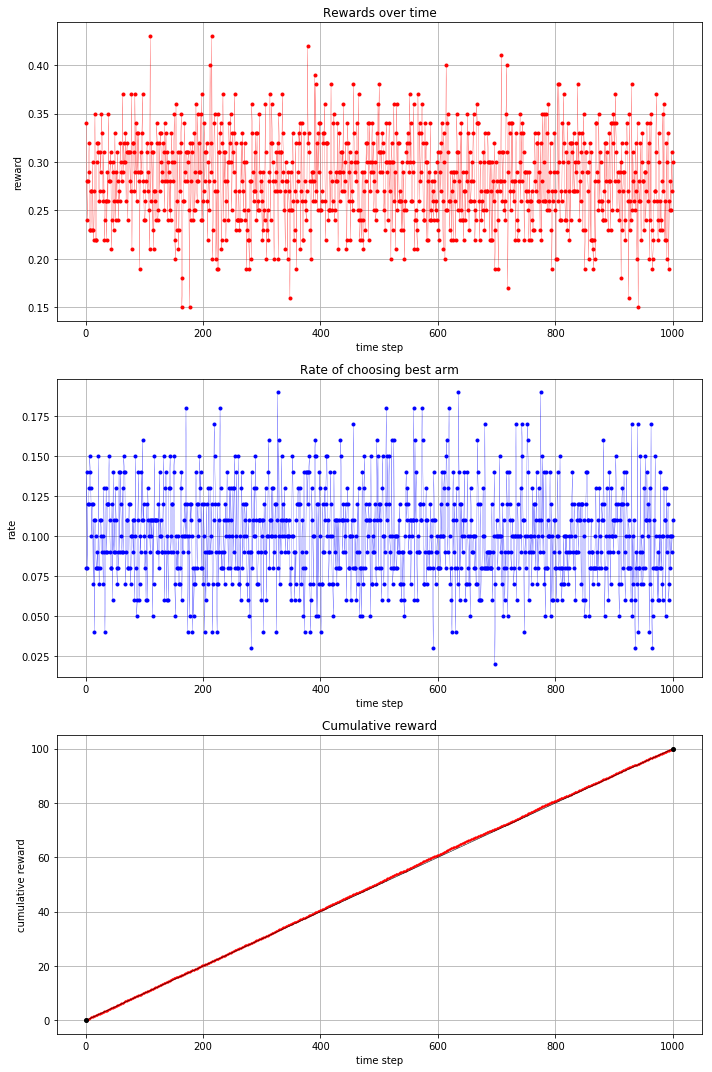

In [67]:
params = {"lr": 0.01}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

## Experimenting with several actor data on same plot

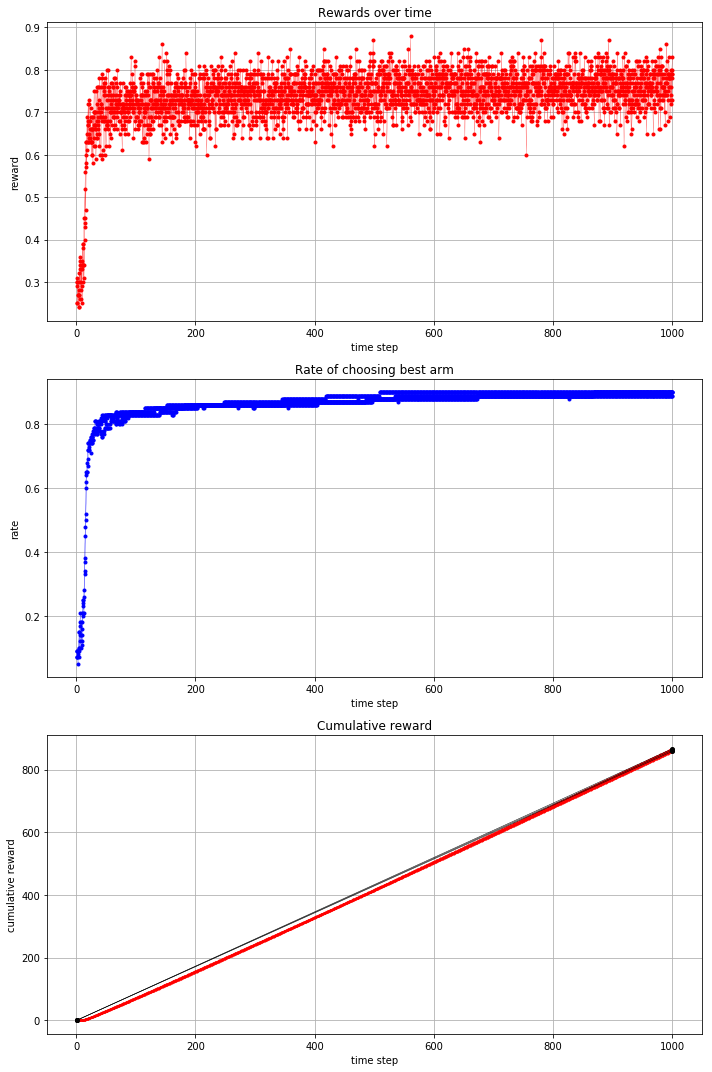

In [453]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent,agent,agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

# down

[go up](#up)